In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import stations

In [5]:
stations_point = gpd.read_file('./clean_data/stations_point.geojson')
stations_area = gpd.read_file('./clean_data/stations_area.geojson')

In [6]:
# radius in km
radius = (stations_area.to_crs(epsg_2d)['geometry'].iloc[0].area / np.pi)**0.5 / 10**3

Text(0.5, 1.0, 'TTC subway stations with radius of 0.40km')

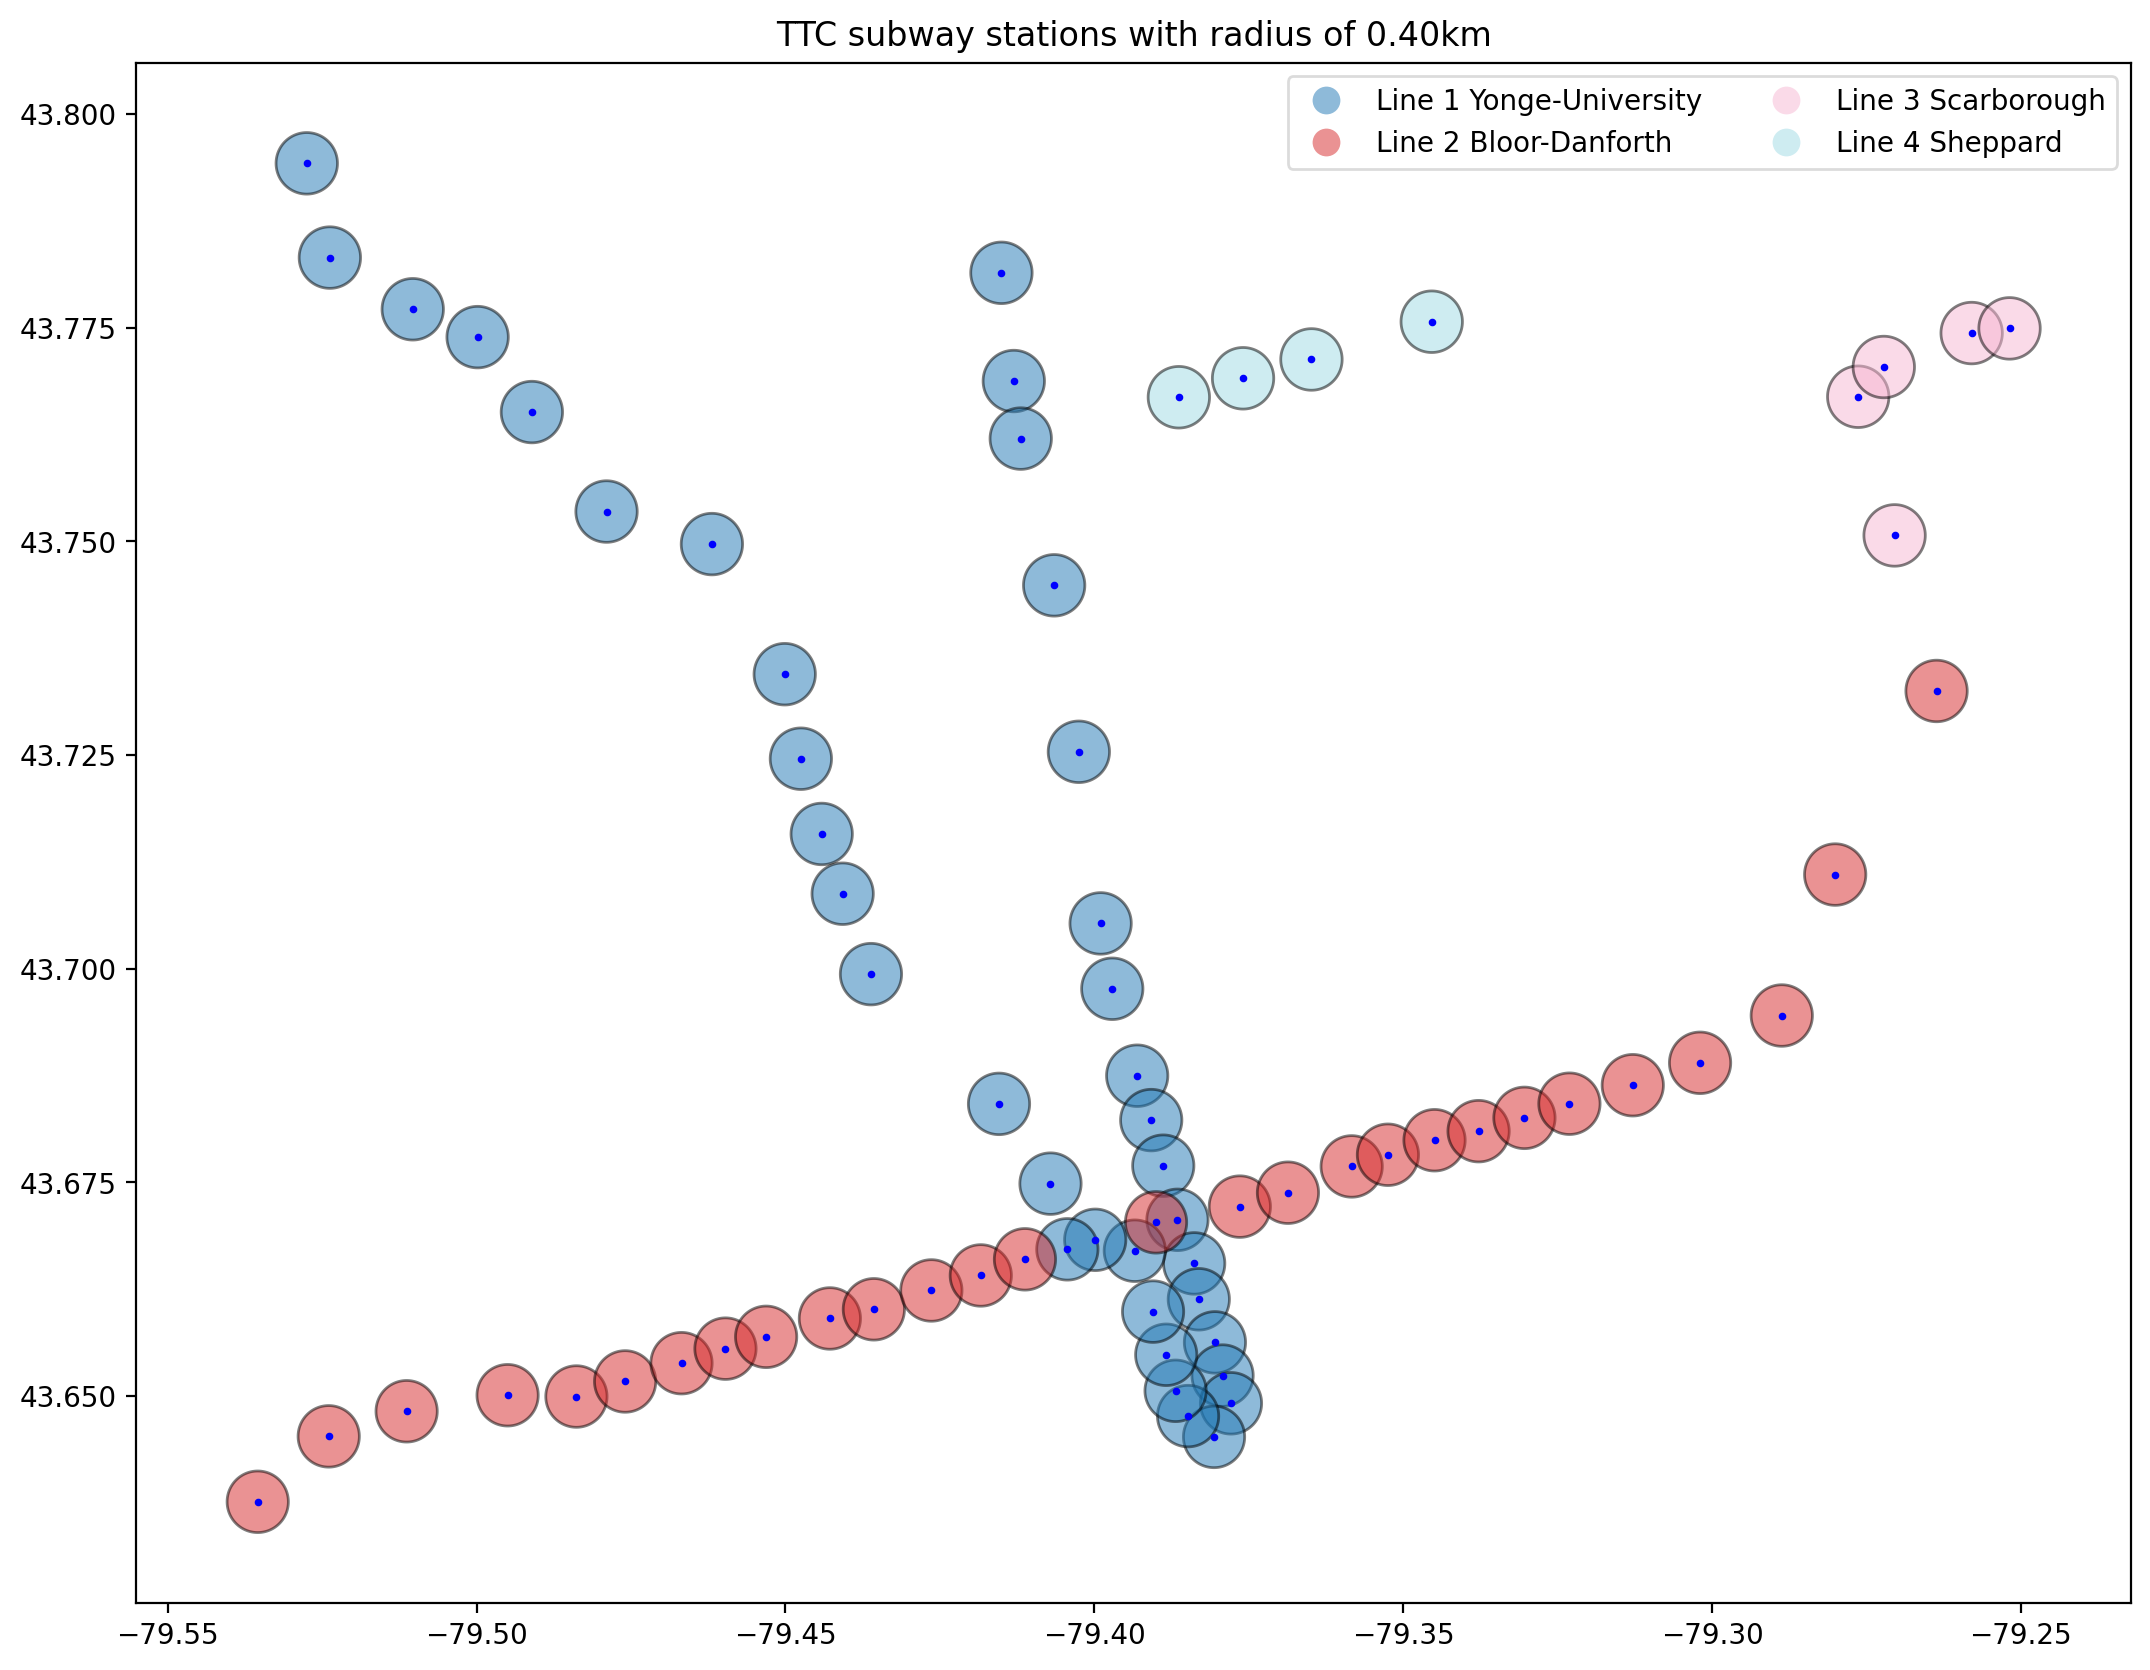

In [7]:
ax = stations_area.plot(column = 'line', 
                        edgecolor = 'black', 
                        alpha = 0.5,
                        cmap = 'tab20',
                        legend = True,
                        legend_kwds = {'loc': 'upper right', 
                                       'ncol': 2,
                                       'edgecolor': 'lightgrey'})
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)
plt.title(f'TTC subway stations with radius of {radius:0.2f}km')

# Import neighbourhoods

In [8]:
neighborhoods = gpd.read_file('./clean_data/neighborhoods.geojson')
neighborhoods.head()

OBJECTID            Neighbourhood Hood_ID  F2020_Population_Projection  \
0         1           Yonge-St.Clair      97                        14083   
1         2  York University Heights      27                        30277   
2         3         Lansing-Westgate      38                        18146   
3         4       Yorkdale-Glen Park      31                        17560   
4         5      Stonegate-Queensway      16                        27410   

   Assault_2014  Assault_2015  Assault_2016  Assault_2017  Assault_2018  \
0            16            25            34            25            28   
1           273           298           363           351           362   
2            42            81            67            84            68   
3           106           137           175           163           178   
4            91            74            78            98            86   

   Assault_2019  ...  Shootings_Rate2015  Shootings_Rate2016  \
0            35  ...            0.000000            7.722008   
1           382  ...            0.000000           13.986990   
2            70  ...            0.000000            5.980146   
3           210  ...           19.752440           19.700550   
4            83  ...            7.788465            0.000000   

   Shootings_Rate2017  Shootings_Rate2018  Shootings_Rate2019  \
0            0.000000            0.000000            0.000000   
1           34.504170           27.189610           20.102520   
2            0.000000            5.737564           11.245430   
3           44.312210           61.042610          100.170900   
4            3.821754            3.759257            3.702744   

   Shootings_Rate2020   Shape__Area  Shape__Length  district  \
0            0.000000  1.161315e+06    5873.270507       C02   
1           39.634040  1.324666e+07   18504.777616       W05   
2            5.510856  5.346186e+06   11112.109419       C07   
3           79.726650  6.038326e+06   10079.426837       W04   
4            0.000000  7.946202e+06   11853.189803       W07   

                                            geometry  
0  POLYGON ((-79.39115 43.68108, -79.39137 43.680...  
1  POLYGON ((-79.50525 43.75987, -79.50484 43.759...  
2  POLYGON ((-79.43994 43.76156, -79.44000 43.761...  
3  POLYGON ((-79.43965 43.70561, -79.44007 43.705...  
4  POLYGON ((-79.49258 43.64744, -79.49273 43.647...  

[5 rows x 106 columns]

In [9]:
neighborhoods.iloc[:,0:4].columns.values

array(['OBJECTID', 'Neighbourhood', 'Hood_ID',
       'F2020_Population_Projection'], dtype=object)

In [10]:
neighborhoods.iloc[:,4:-4].columns.values

array(['Assault_2014', 'Assault_2015', 'Assault_2016', 'Assault_2017',
       'Assault_2018', 'Assault_2019', 'Assault_2020', 'Assault_Rate2014',
       'Assault_Rate2015', 'Assault_Rate2016', 'Assault_Rate2017',
       'Assault_Rate2018', 'Assault_Rate2019', 'Assault_Rate2020',
       'AutoTheft_2014', 'AutoTheft_2015', 'AutoTheft_2016',
       'AutoTheft_2017', 'AutoTheft_2018', 'AutoTheft_2019',
       'AutoTheft_2020', 'AutoTheft_Rate2014', 'AutoTheft_Rate2015',
       'AutoTheft_Rate2016', 'AutoTheft_Rate2017', 'AutoTheft_Rate2018',
       'AutoTheft_Rate2019', 'AutoTheft_Rate2020', 'BreakAndEnter_2014',
       'BreakAndEnter_2015', 'BreakAndEnter_2016', 'BreakAndEnter_2017',
       'BreakAndEnter_2018', 'BreakAndEnter_2019', 'BreakAndEnter_2020',
       'BreakAndEnter_Rate2014', 'BreakAndEnter_Rate2015',
       'BreakAndEnter_Rate2016', 'BreakAndEnter_Rate2017',
       'BreakAndEnter_Rate2018', 'BreakAndEnter_Rate2019',
       'BreakAndEnter_Rate2020', 'Robbery_2014', 'Robbery_20

In [11]:
crime_counts = sorted(list(set([re.search('[a-zA-Z]+', x).group(0) for x in neighborhoods.iloc[:,4:-4].columns.values])))
crime_counts

['Assault',
 'AutoTheft',
 'BreakAndEnter',
 'Homicide',
 'Robbery',
 'RobberyRate',
 'Shooting',
 'Shootings',
 'TheftOver']

In [12]:
# RobberyRate_2015 and Shooting_Rate2014 are in a different format vs other crime rates
[x for x in neighborhoods.columns.values if ('RobberyRate' in x) | ('Shooting_Rate' in x)]

['RobberyRate_2015', 'Shooting_Rate2014']

In [13]:
neighborhoods.rename(columns={'RobberyRate_2015': 'Robbery_Rate2015',
                              'Shooting_Rate2014': 'Shootings_Rate2014'},
                     inplace=True)

In [14]:
# now crime counts are correct
crime_counts = sorted(list(set([re.search('[a-zA-Z]+', x).group(0) for x in neighborhoods.iloc[:,4:-4].columns.values])))
crime_counts

['Assault',
 'AutoTheft',
 'BreakAndEnter',
 'Homicide',
 'Robbery',
 'Shootings',
 'TheftOver']

In [15]:
# now crime rates are correct
crime_rates = sorted(list(set([re.search('[a-zA-Z]+_Rate', x).group(0) for x in neighborhoods.columns.values if re.search('[a-zA-Z]+_Rate', x) is not None])))
crime_rates

['Assault_Rate',
 'AutoTheft_Rate',
 'BreakAndEnter_Rate',
 'Homicide_Rate',
 'Robbery_Rate',
 'Shootings_Rate',
 'TheftOver_Rate']

In [16]:
years = sorted(list(set([re.search('[0-9]+', x).group(0) for x in neighborhoods.iloc[:,4:-4].columns.values])))
years

['2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [17]:
# crime density = crime count / area in 1 km^2
for x in crime_counts:
    for year in years:
        neighborhoods[x + '_Density' + str(year)] = neighborhoods[x + '_' + str(year)] / (neighborhoods['geometry'].to_crs(epsg_2d).area / 10**6)

In [18]:
crime_density = sorted(list(set([re.search('[a-zA-Z]+_Density', x).group(0) for x in neighborhoods.columns.values if re.search('[a-zA-Z]+_Density', x) is not None])))
crime_density

['Assault_Density',
 'AutoTheft_Density',
 'BreakAndEnter_Density',
 'Homicide_Density',
 'Robbery_Density',
 'Shootings_Density',
 'TheftOver_Density']

In [19]:
for year in years:
    neighborhoods['All_' + str(year)] = neighborhoods[[x + "_" + str(year)for x in crime_counts]].sum(axis=1)
    neighborhoods['Population_' + str(year)] = (neighborhoods[[x + "_" + str(year)for x in crime_counts]] / neighborhoods[[x + "_Rate" + str(year)for x in crime_counts]].values).fillna(axis=1, method='bfill').replace([np.inf, -np.inf], np.nan).fillna(axis=1, method='ffill').mean(axis=1)*10**5
    print(f"{year} Population in City of Toronto is {neighborhoods['Population_' + str(year)].sum():0,.0f}")
    neighborhoods['All_Rate' + str(year)] = neighborhoods['All_' + str(year)] / neighborhoods['Population_' + str(year)] * 10**5
    neighborhoods['All_Density' + str(year)] = neighborhoods['All_' + str(year)] / (neighborhoods['geometry'].to_crs(epsg_2d).area / 10**6)

2014 Population in City of Toronto is 2,776,942
2015 Population in City of Toronto is 2,795,256
2016 Population in City of Toronto is 2,822,888
2017 Population in City of Toronto is 2,875,230
2018 Population in City of Toronto is 2,917,481
2019 Population in City of Toronto is 2,987,098
2020 Population in City of Toronto is 3,042,042


In [20]:
crime_rates = sorted(list(set([re.search('[a-zA-Z]+_Rate', x).group(0) for x in neighborhoods.columns.values if re.search('[a-zA-Z]+_Rate', x) is not None])))
crime_rates

['All_Rate',
 'Assault_Rate',
 'AutoTheft_Rate',
 'BreakAndEnter_Rate',
 'Homicide_Rate',
 'Robbery_Rate',
 'Shootings_Rate',
 'TheftOver_Rate']

In [21]:
crime_density = sorted(list(set([re.search('[a-zA-Z]+_Density', x).group(0) for x in neighborhoods.columns.values if re.search('[a-zA-Z]+_Density', x) is not None])))
crime_density

['All_Density',
 'Assault_Density',
 'AutoTheft_Density',
 'BreakAndEnter_Density',
 'Homicide_Density',
 'Robbery_Density',
 'Shootings_Density',
 'TheftOver_Density']

In [22]:
def plot_crime(var, title):
    fig, axes = plt.subplots(len(years), len(var))

    for j in range(axes.shape[1]):
        # fix the range for the colorbar so we can compare across years for each crime rate
        vmin, vmax = neighborhoods[[var[j] + str(year) for year in years]].min().min(), neighborhoods[[var[j] + str(year) for year in years]].max().max()
        norm = TwoSlopeNorm(vmin=vmin, vcenter= np.mean([vmin, vmax]), vmax=vmax)
        for i in range(axes.shape[0]):    
            neighborhoods.plot(column = var[j] + str(years[i]), 
                            cmap = 'viridis',
                            norm = norm,
                            #    legend = True,
                            ax = axes[i, j])
            # x.set_title(col)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].set_yticks([])
            if i == 0:
                axes[i,j].set_title(var[j].split("_")[0])
            if j == 0:
                axes[i,j].set_ylabel(years[i], rotation=90, size='large')

    # fig.tight_layout()

    fig.suptitle(title, size='xx-large')

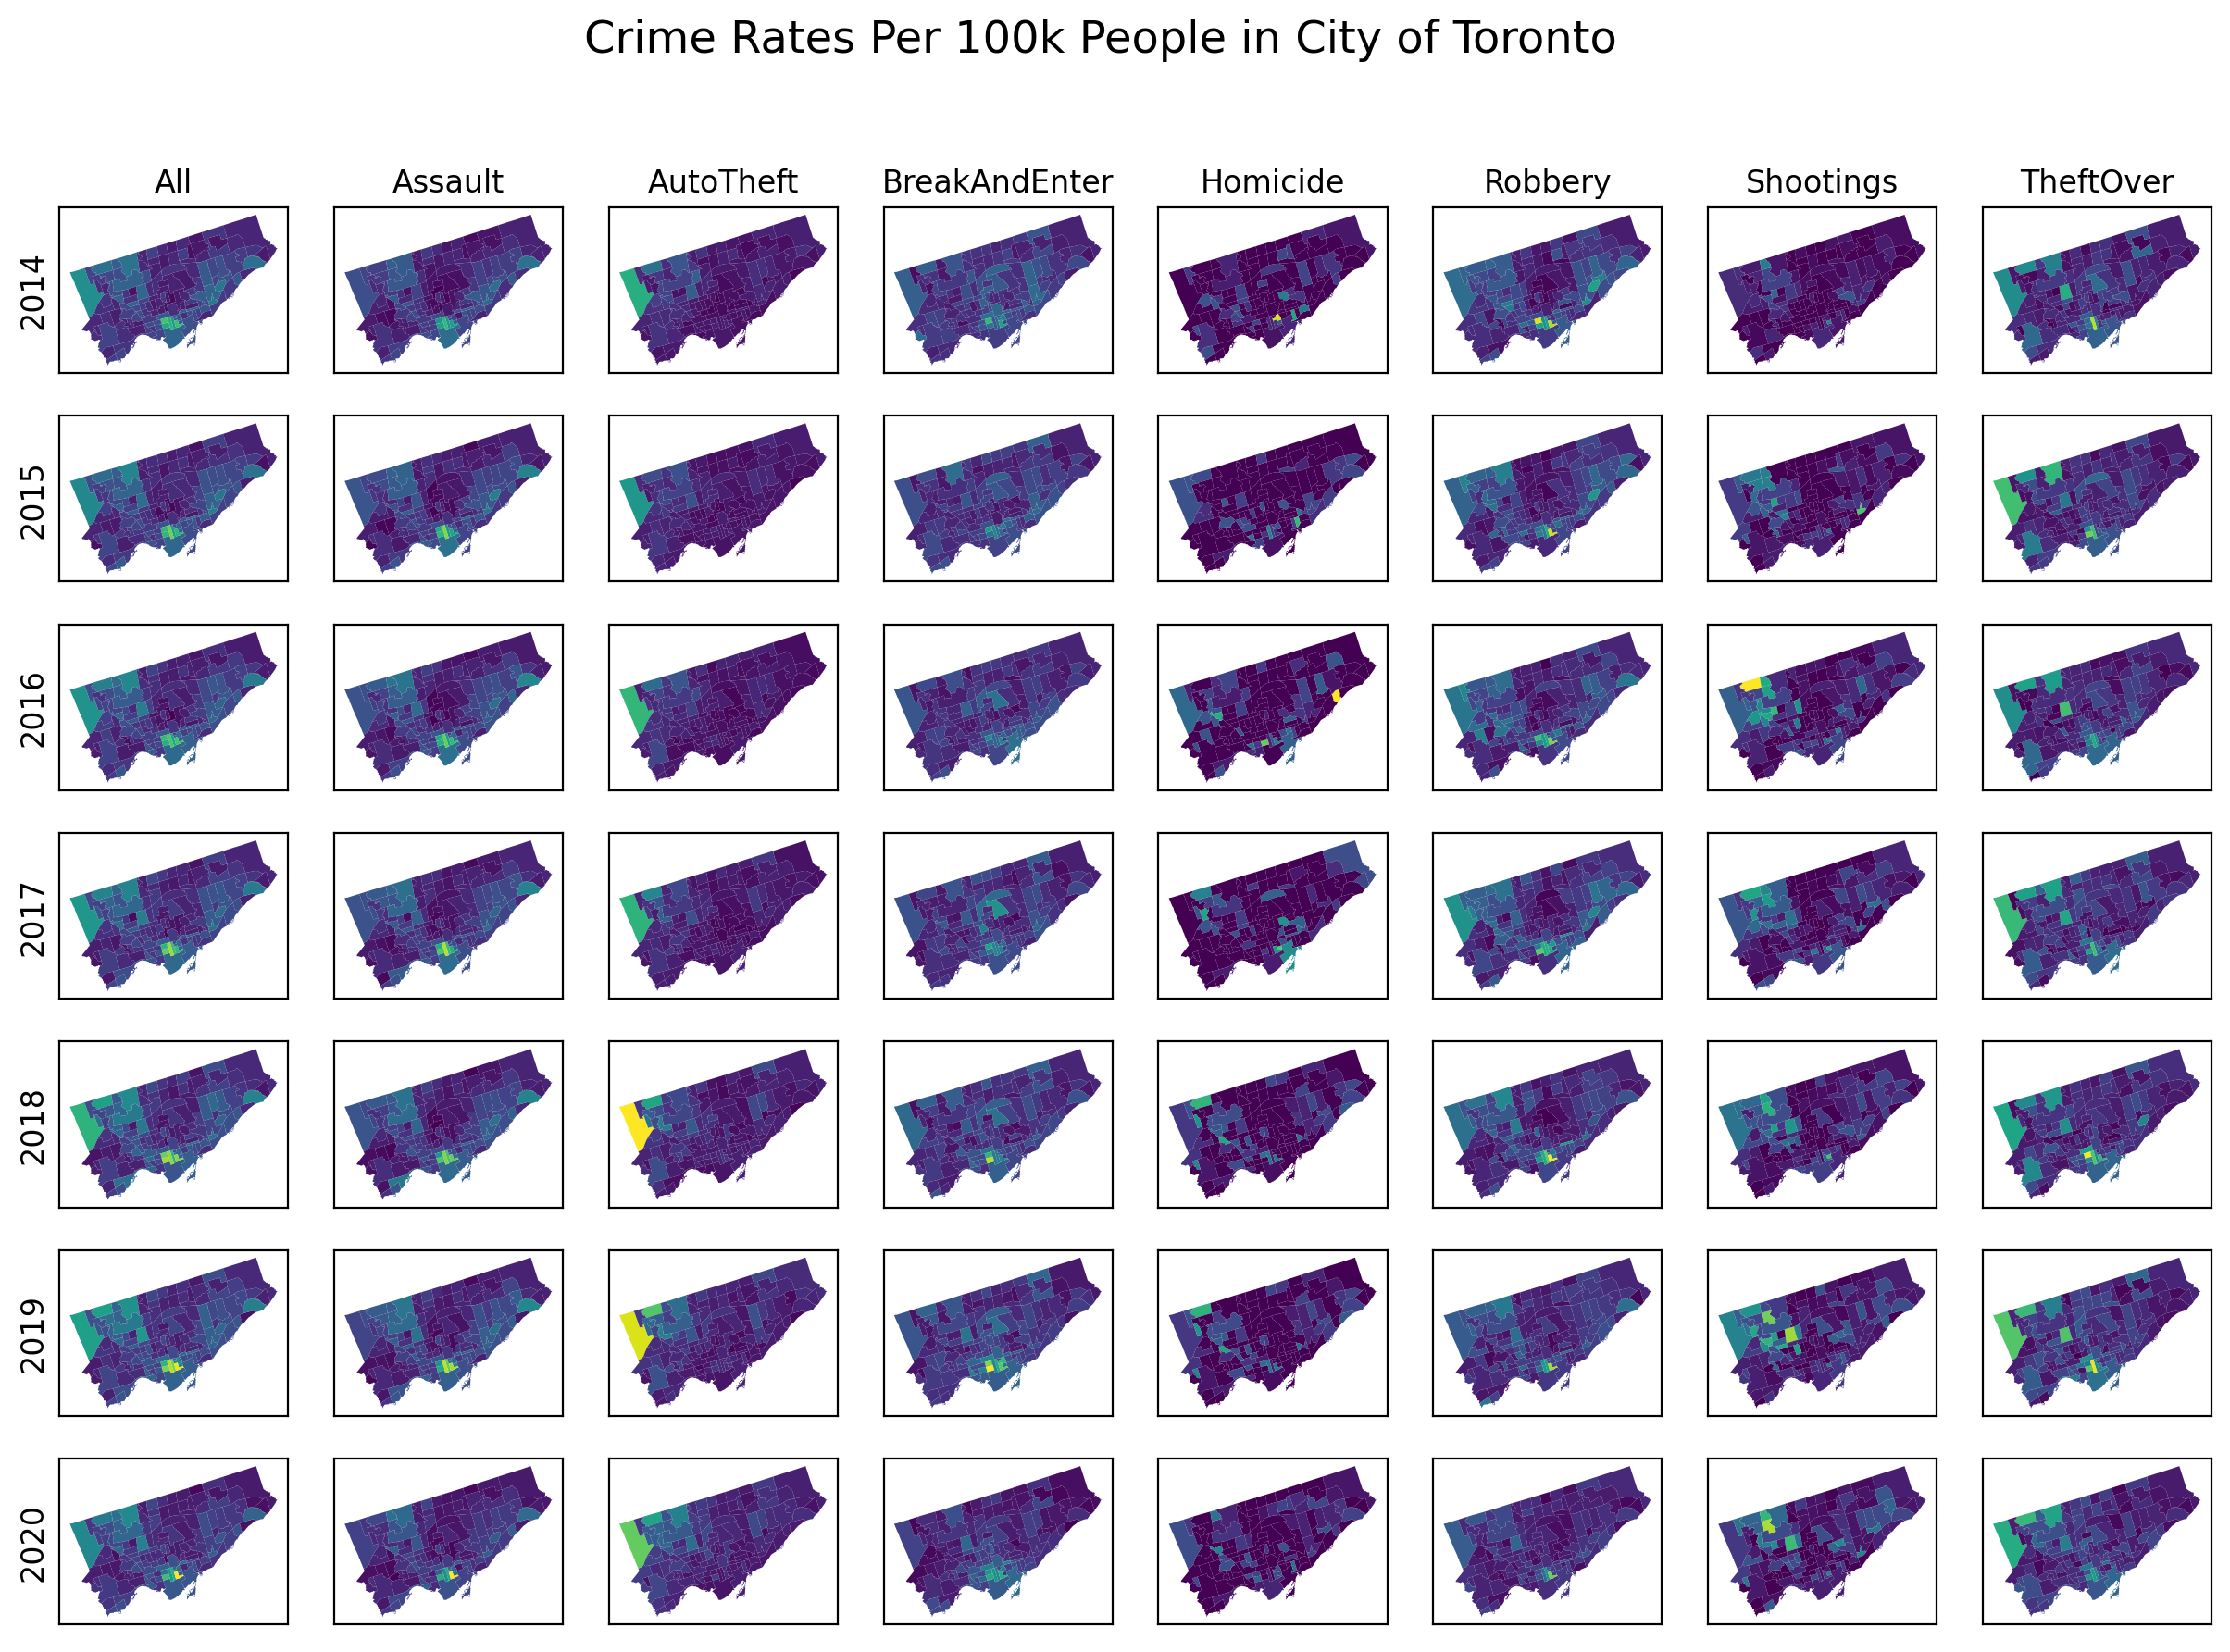

In [23]:
plot_crime(crime_rates, 'Crime Rates Per 100k People in City of Toronto')

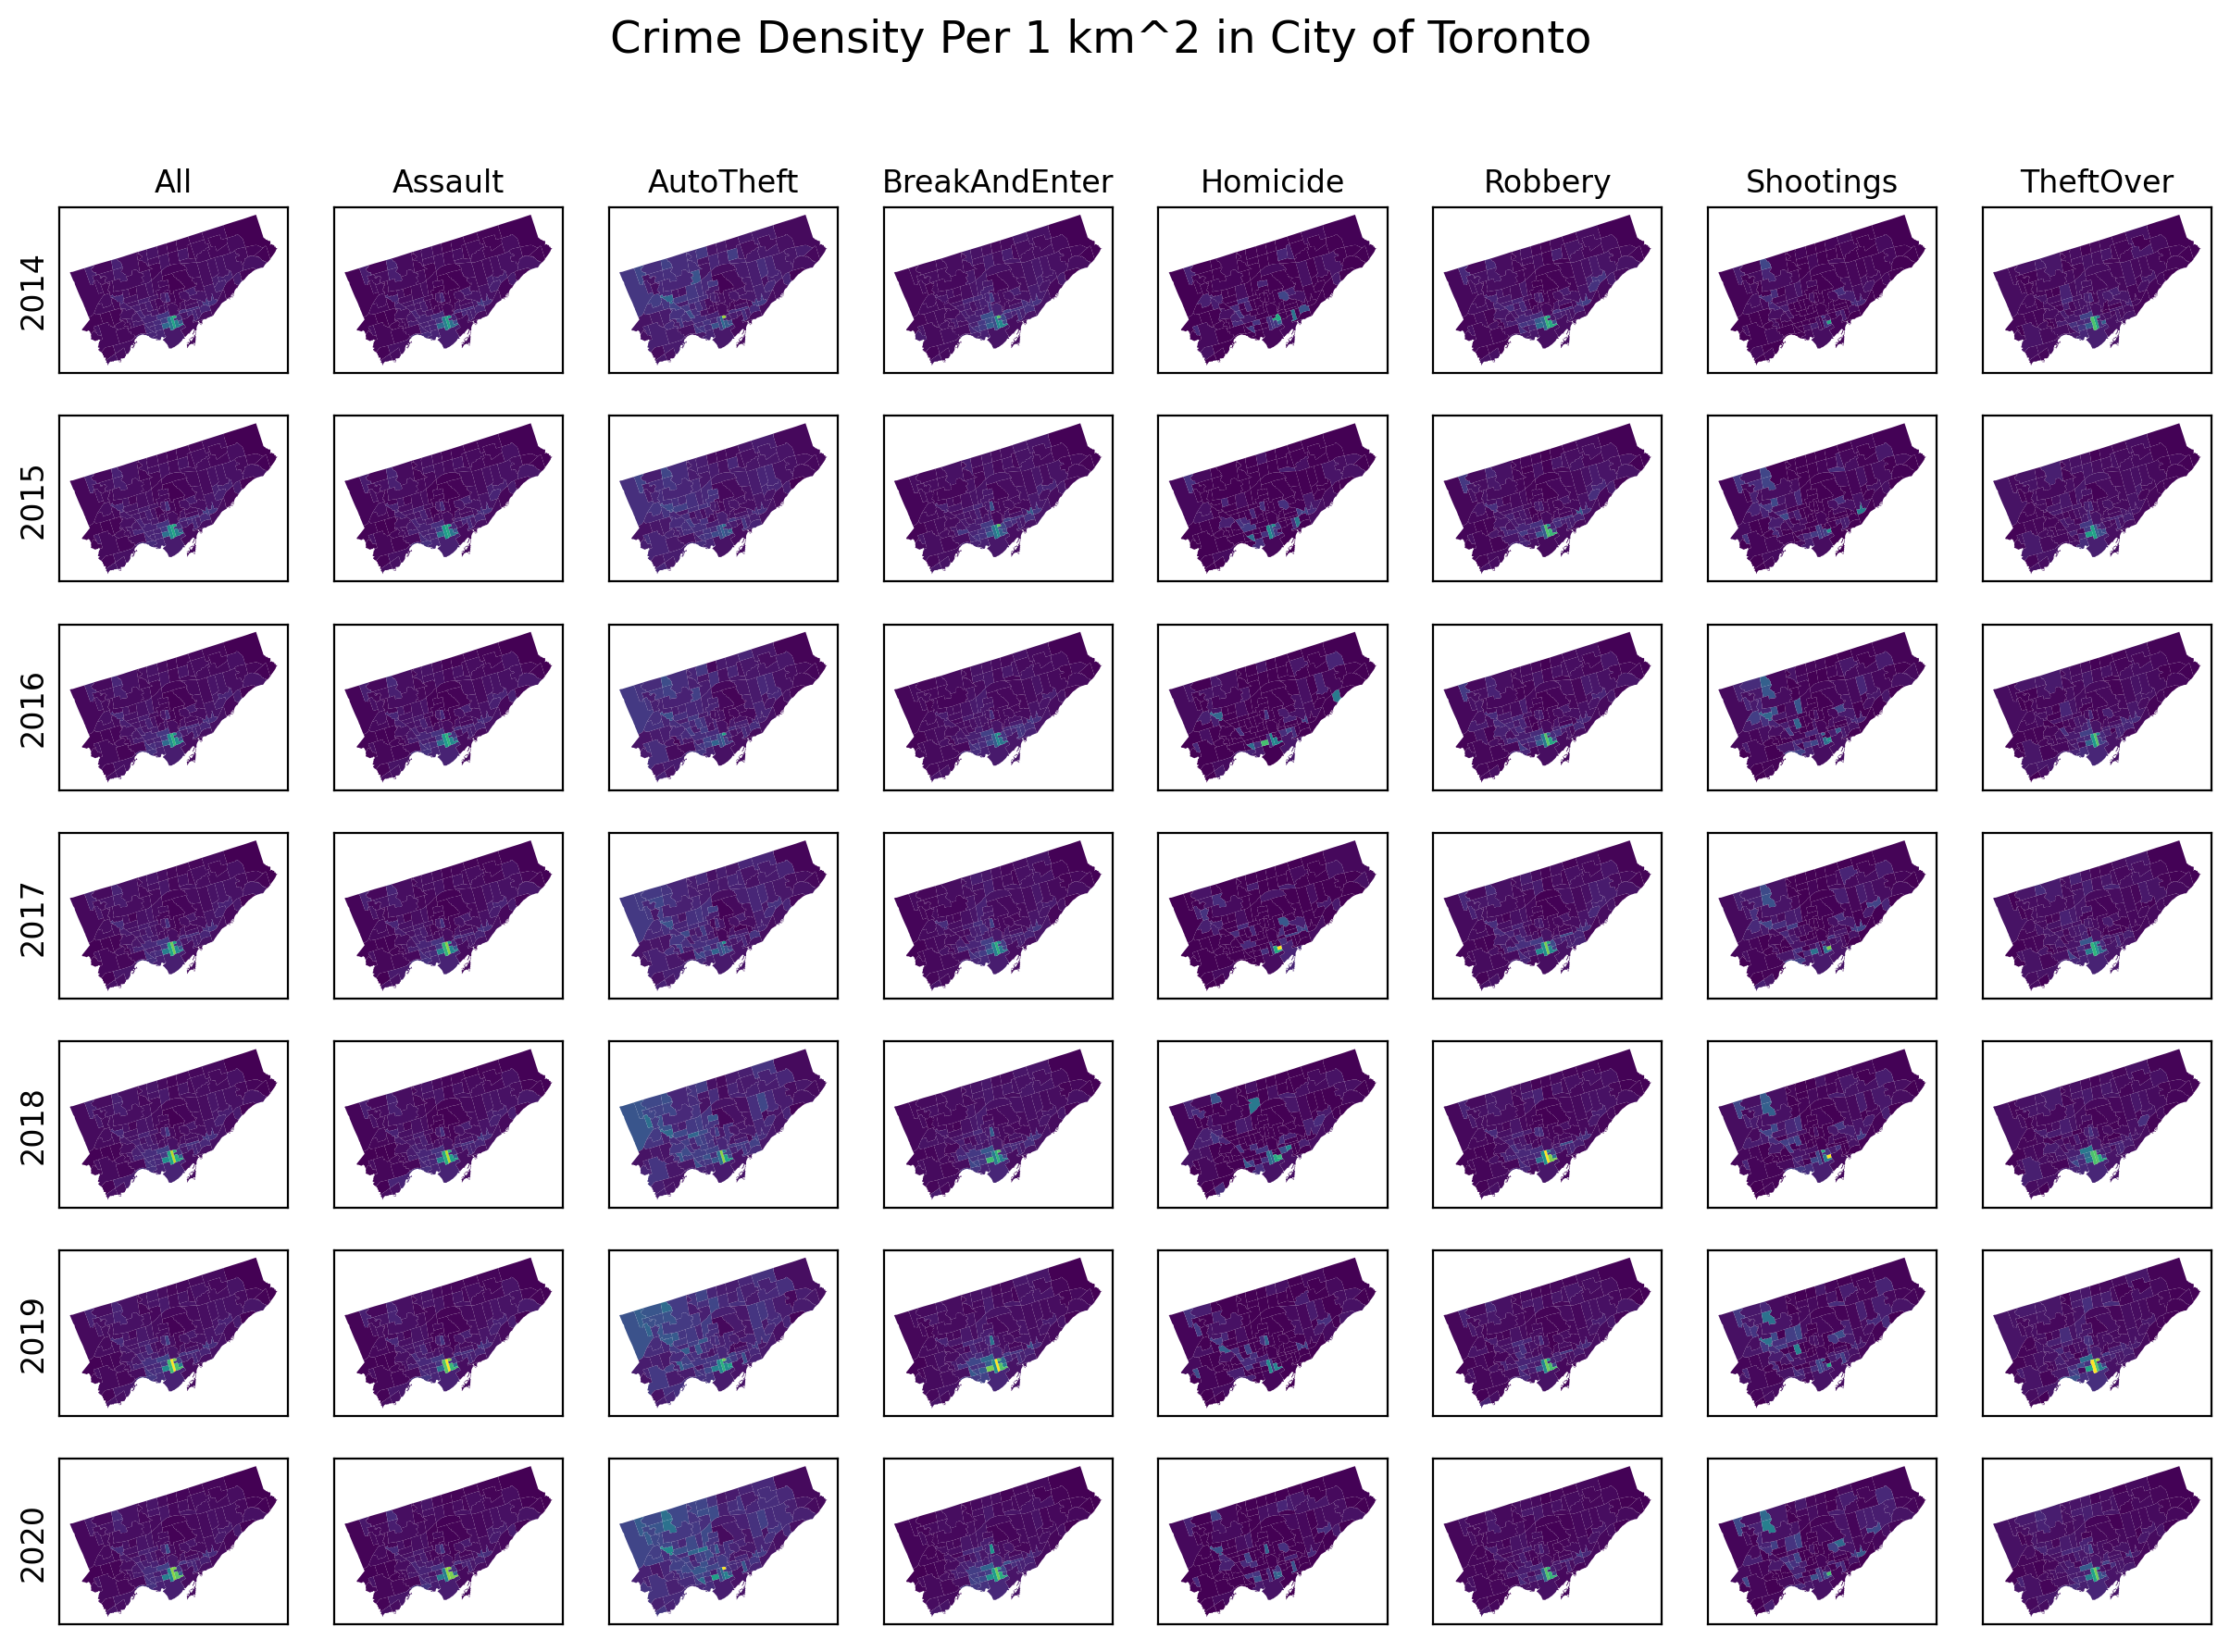

In [24]:
plot_crime(crime_density, 'Crime Density Per 1 km^2 in City of Toronto')

In [25]:
# plotly version
# crime_allrate = pd.wide_to_long(neighborhoods[['Neighbourhood', 'Hood_ID', 'geometry'] + ['All_Rate' + str(year) for year in years]], 
#                                   stubnames= "All_Rate", 
#                                   i=['Neighbourhood', 'Hood_ID'], 
#                                   j='year',
#                                   sep='').reset_index()

# crime_allrate.head()

# fig = px.choropleth(crime_allrate, 
#               geojson=crime_allrate.geometry,
#               locations=crime_allrate.index,
#               color = 'All_Rate',
#               animation_frame='year',
#               color_continuous_scale="Viridis",
#               hover_data=['Neighbourhood'])
# fig.update_geos(fitbounds="locations", visible=False)

In [26]:
neighborhoods[crime_rates[0] + '2020'].min()

386.4591048544157

Text(0.5, 257.52801096780723, 'Longitude')

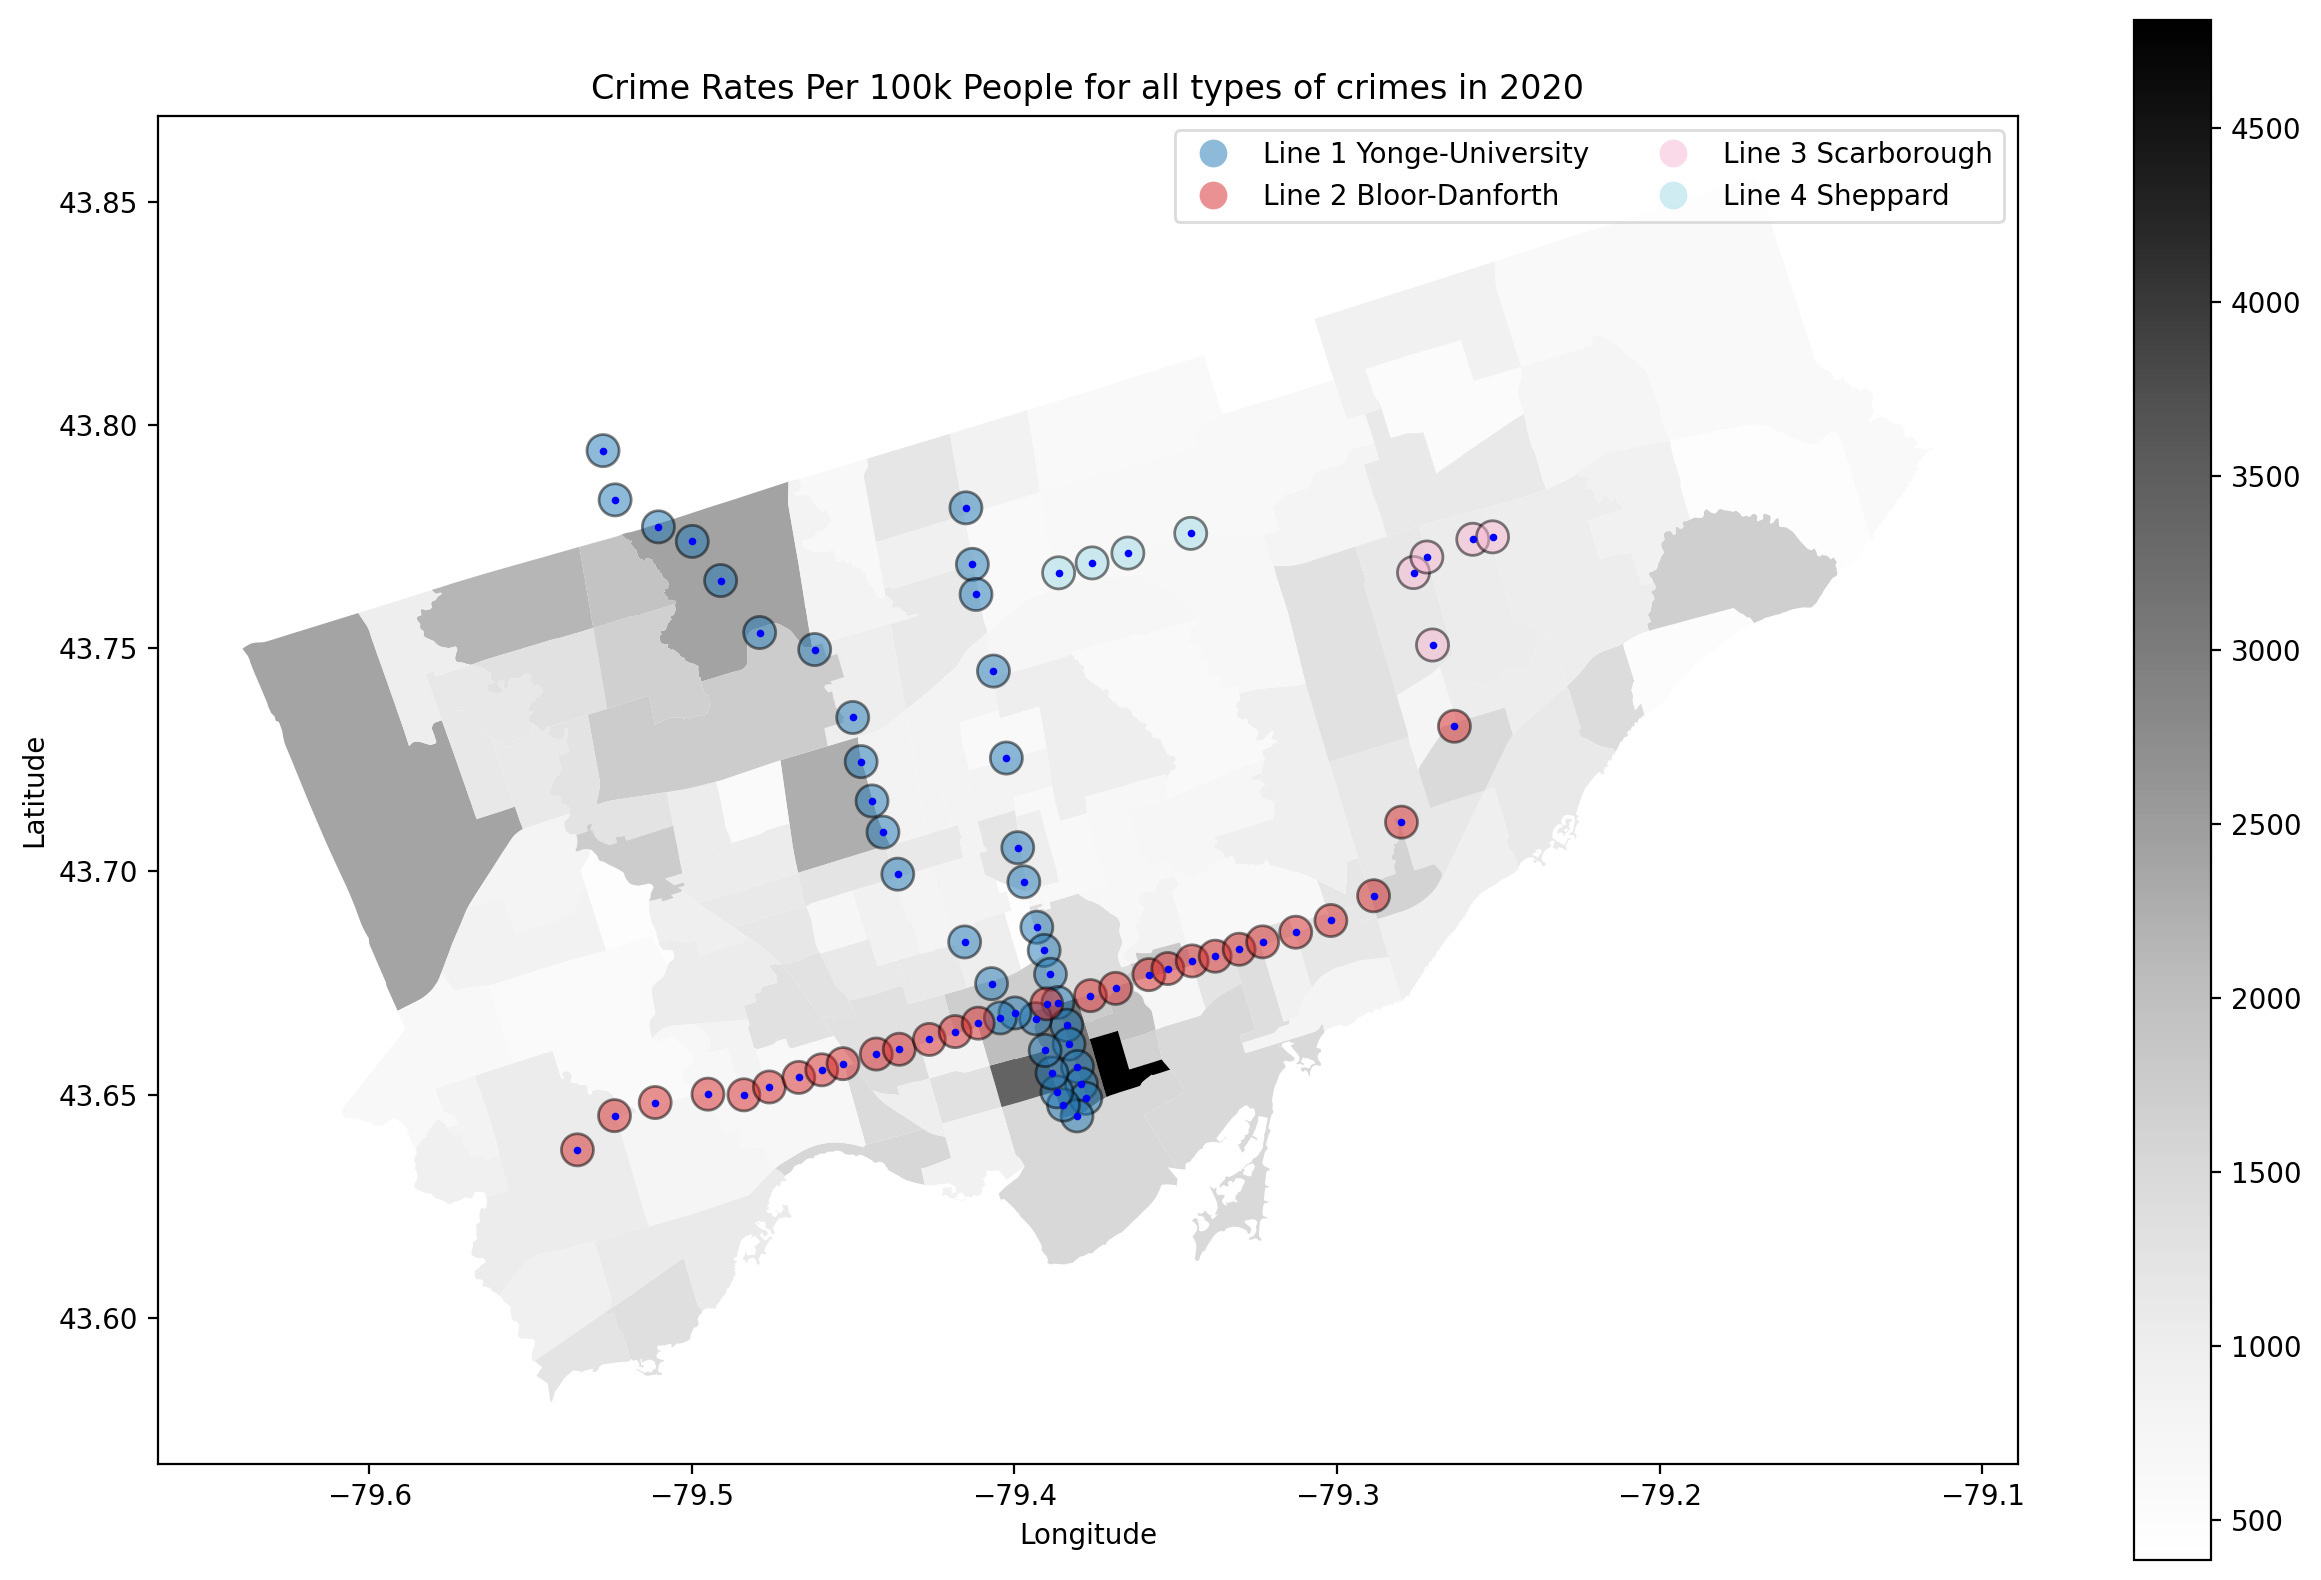

In [27]:
var = crime_rates
j = 0
year = 2020
ax = neighborhoods.plot(column = var[j] + str(year), 
                cmap = 'Greys',
                # norm = norm,
                legend = True)

stations_area.plot(column = 'line', 
                edgecolor = 'black', 
                alpha = 0.5,
                cmap = 'tab20',
                legend = True,
                legend_kwds = {'loc': 'upper right', 
                                'ncol': 2,
                                'edgecolor': 'lightgrey'},
                ax = ax)
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)

ax.set_title("Crime Rates Per 100k People for all types of crimes in " + str(year))
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

# Import rental

In [28]:
rental = pd.read_csv("./clean_data/rental.csv")
rental

Region  All_Apartments_Total_Listed  All_Apartments_Total_Leased  \
0       W01                         66.0                         32.0   
1       W02                         13.0                          9.0   
2       W03                          3.0                          3.0   
3       W04                         10.0                          2.0   
4       W05                         43.0                         17.0   
...     ...                          ...                          ...   
1395    E07                        125.0                         99.0   
1396    E08                         73.0                         35.0   
1397    E09                        226.0                        188.0   
1398    E10                         32.0                         22.0   
1399    E11                         44.0                         28.0   

      Bachelor_Bachelor_Leased  Bachelor_Avg_Lease_Rate  \
0                          NaN                      NaN   
1                          NaN                      NaN   
2                          NaN                      NaN   
3                          NaN                      NaN   
4                          NaN                      NaN   
...                        ...                      ...   
1395                       NaN                      NaN   
1396                       NaN                      NaN   
1397                       5.0                   1698.0   
1398                       NaN                      NaN   
1399                       NaN                      NaN   

      One_Bedroom_Bachelor_Leased  One_Bedroom_Avg_Lease_Rate  \
0                            24.0                      1539.0   
1                             3.0                      1633.0   
2                             2.0                      1050.0   
3                             1.0                      1150.0   
4                            12.0                      1354.0   
...                           ...                         ...   
1395                         41.0                      1976.0   
1396                         12.0                      1824.0   
1397                        111.0                      2080.0   
1398                         14.0                      1813.0   
1399                         12.0                      1932.0   

      Two_Bedroom_Bachelor_Leased  Two_Bedroom_Avg_Lease_Rate  \
0                             8.0                      2031.0   
1                             6.0                      1679.0   
2                             1.0                      1650.0   
3                             1.0                      1350.0   
4                             5.0                      1578.0   
...                           ...                         ...   
1395                         54.0                      2408.0   
1396                         16.0                      2215.0   
1397                         68.0                      2770.0   
1398                          7.0                      2399.0   
1399                         16.0                      2175.0   

      Three_Bedroom_Bachelor_Leased  Three_Bedroom_Avg_Lease_Rate  Year  \
0                               NaN                           NaN  2012   
1                               NaN                           NaN  2012   
2                               NaN                           NaN  2012   
3                               NaN                           NaN  2012   
4                               NaN                           NaN  2012   
...                             ...                           ...   ...   
1395                            4.0                        2645.0  2021   
1396                            7.0                        2543.0  2021   
1397                            4.0                        3275.0  2021   
1398                            1.0                        2700.0  2021   
1399                            

In [29]:
neighborhoods_rental = neighborhoods[['Neighbourhood', 'Hood_ID', 'district', 'geometry']].merge(rental, left_on='district', right_on='Region')
neighborhoods_rental

Neighbourhood Hood_ID district  \
0          Yonge-St.Clair      97      C02   
1          Yonge-St.Clair      97      C02   
2          Yonge-St.Clair      97      C02   
3          Yonge-St.Clair      97      C02   
4          Yonge-St.Clair      97      C02   
...                   ...     ...      ...   
5595  Mount Pleasant West     104      C10   
5596  Mount Pleasant West     104      C10   
5597  Mount Pleasant West     104      C10   
5598  Mount Pleasant West     104      C10   
5599  Mount Pleasant West     104      C10   

                                               geometry Region  \
0     POLYGON ((-79.39115 43.68108, -79.39137 43.680...    C02   
1     POLYGON ((-79.39115 43.68108, -79.39137 43.680...    C02   
2     POLYGON ((-79.39115 43.68108, -79.39137 43.680...    C02   
3     POLYGON ((-79.39115 43.68108, -79.39137 43.680...    C02   
4     POLYGON ((-79.39115 43.68108, -79.39137 43.680...    C02   
...                                                 ...    ...   
5595  POLYGON ((-79.39607 43.69566, -79.39616 43.696...    C10   
5596  POLYGON ((-79.39607 43.69566, -79.39616 43.696...    C10   
5597  POLYGON ((-79.39607 43.69566, -79.39616 43.696...    C10   
5598  POLYGON ((-79.39607 43.69566, -79.39616 43.696...    C10   
5599  POLYGON ((-79.39607 43.69566, -79.39616 43.696...    C10   

      All_Apartments_Total_Listed  All_Apartments_Total_Leased  \
0                           179.0                         92.0   
1                           214.0                        105.0   
2                           234.0                        107.0   
3                           226.0                         82.0   
4                           273.0                         95.0   
...                           ...                          ...   
5595                       1038.0                        404.0   
5596                        970.0                        416.0   
5597                       1064.0                        608.0   
5598                       1031.0                        767.0   
5599                        593.0                        384.0   

      Bachelor_Bachelor_Leased  Bachelor_Avg_Lease_Rate  \
0                          4.0                   1463.0   
1                          6.0                   1418.0   
2                          5.0                   1254.0   
3                          4.0                   1406.0   
4                          4.0                   1445.0   
...                        ...                      ...   
5595                      15.0                   1489.0   
5596                      16.0                   1425.0   
5597                      21.0                   1473.0   
5598                      40.0                   1566.0   
5599                      16.0                   1666.0   

      One_Bedroom_Bachelor_Leased  One_Bedroom_Avg_Lease_Rate  \
0                            45.0                      2029.0   
1                            50.0                      1939.0   
2                            57.0                      2100.0   
3                            46.0                      2115.0   
4                            41.0                      2351.0   
...                           ...                         ...   
5595                        267.0                      1828.0   
5596                        281.0                      1779.0   
5597                        409.0                      1789.0   
5598                        501.0                      1896.0   
5599                        242.0                      2008.0   

      Two_Bedroom_Bachelor_Leased  Two_Bedroom_Avg_Lease_Rate  \
0                            42.0                      4104.0   
1                            45.0                      3918.0   
2                            41.0                      4019.0   
3                            29.0                      3397.0   
4                            47.0                      424

<AxesSubplot:>

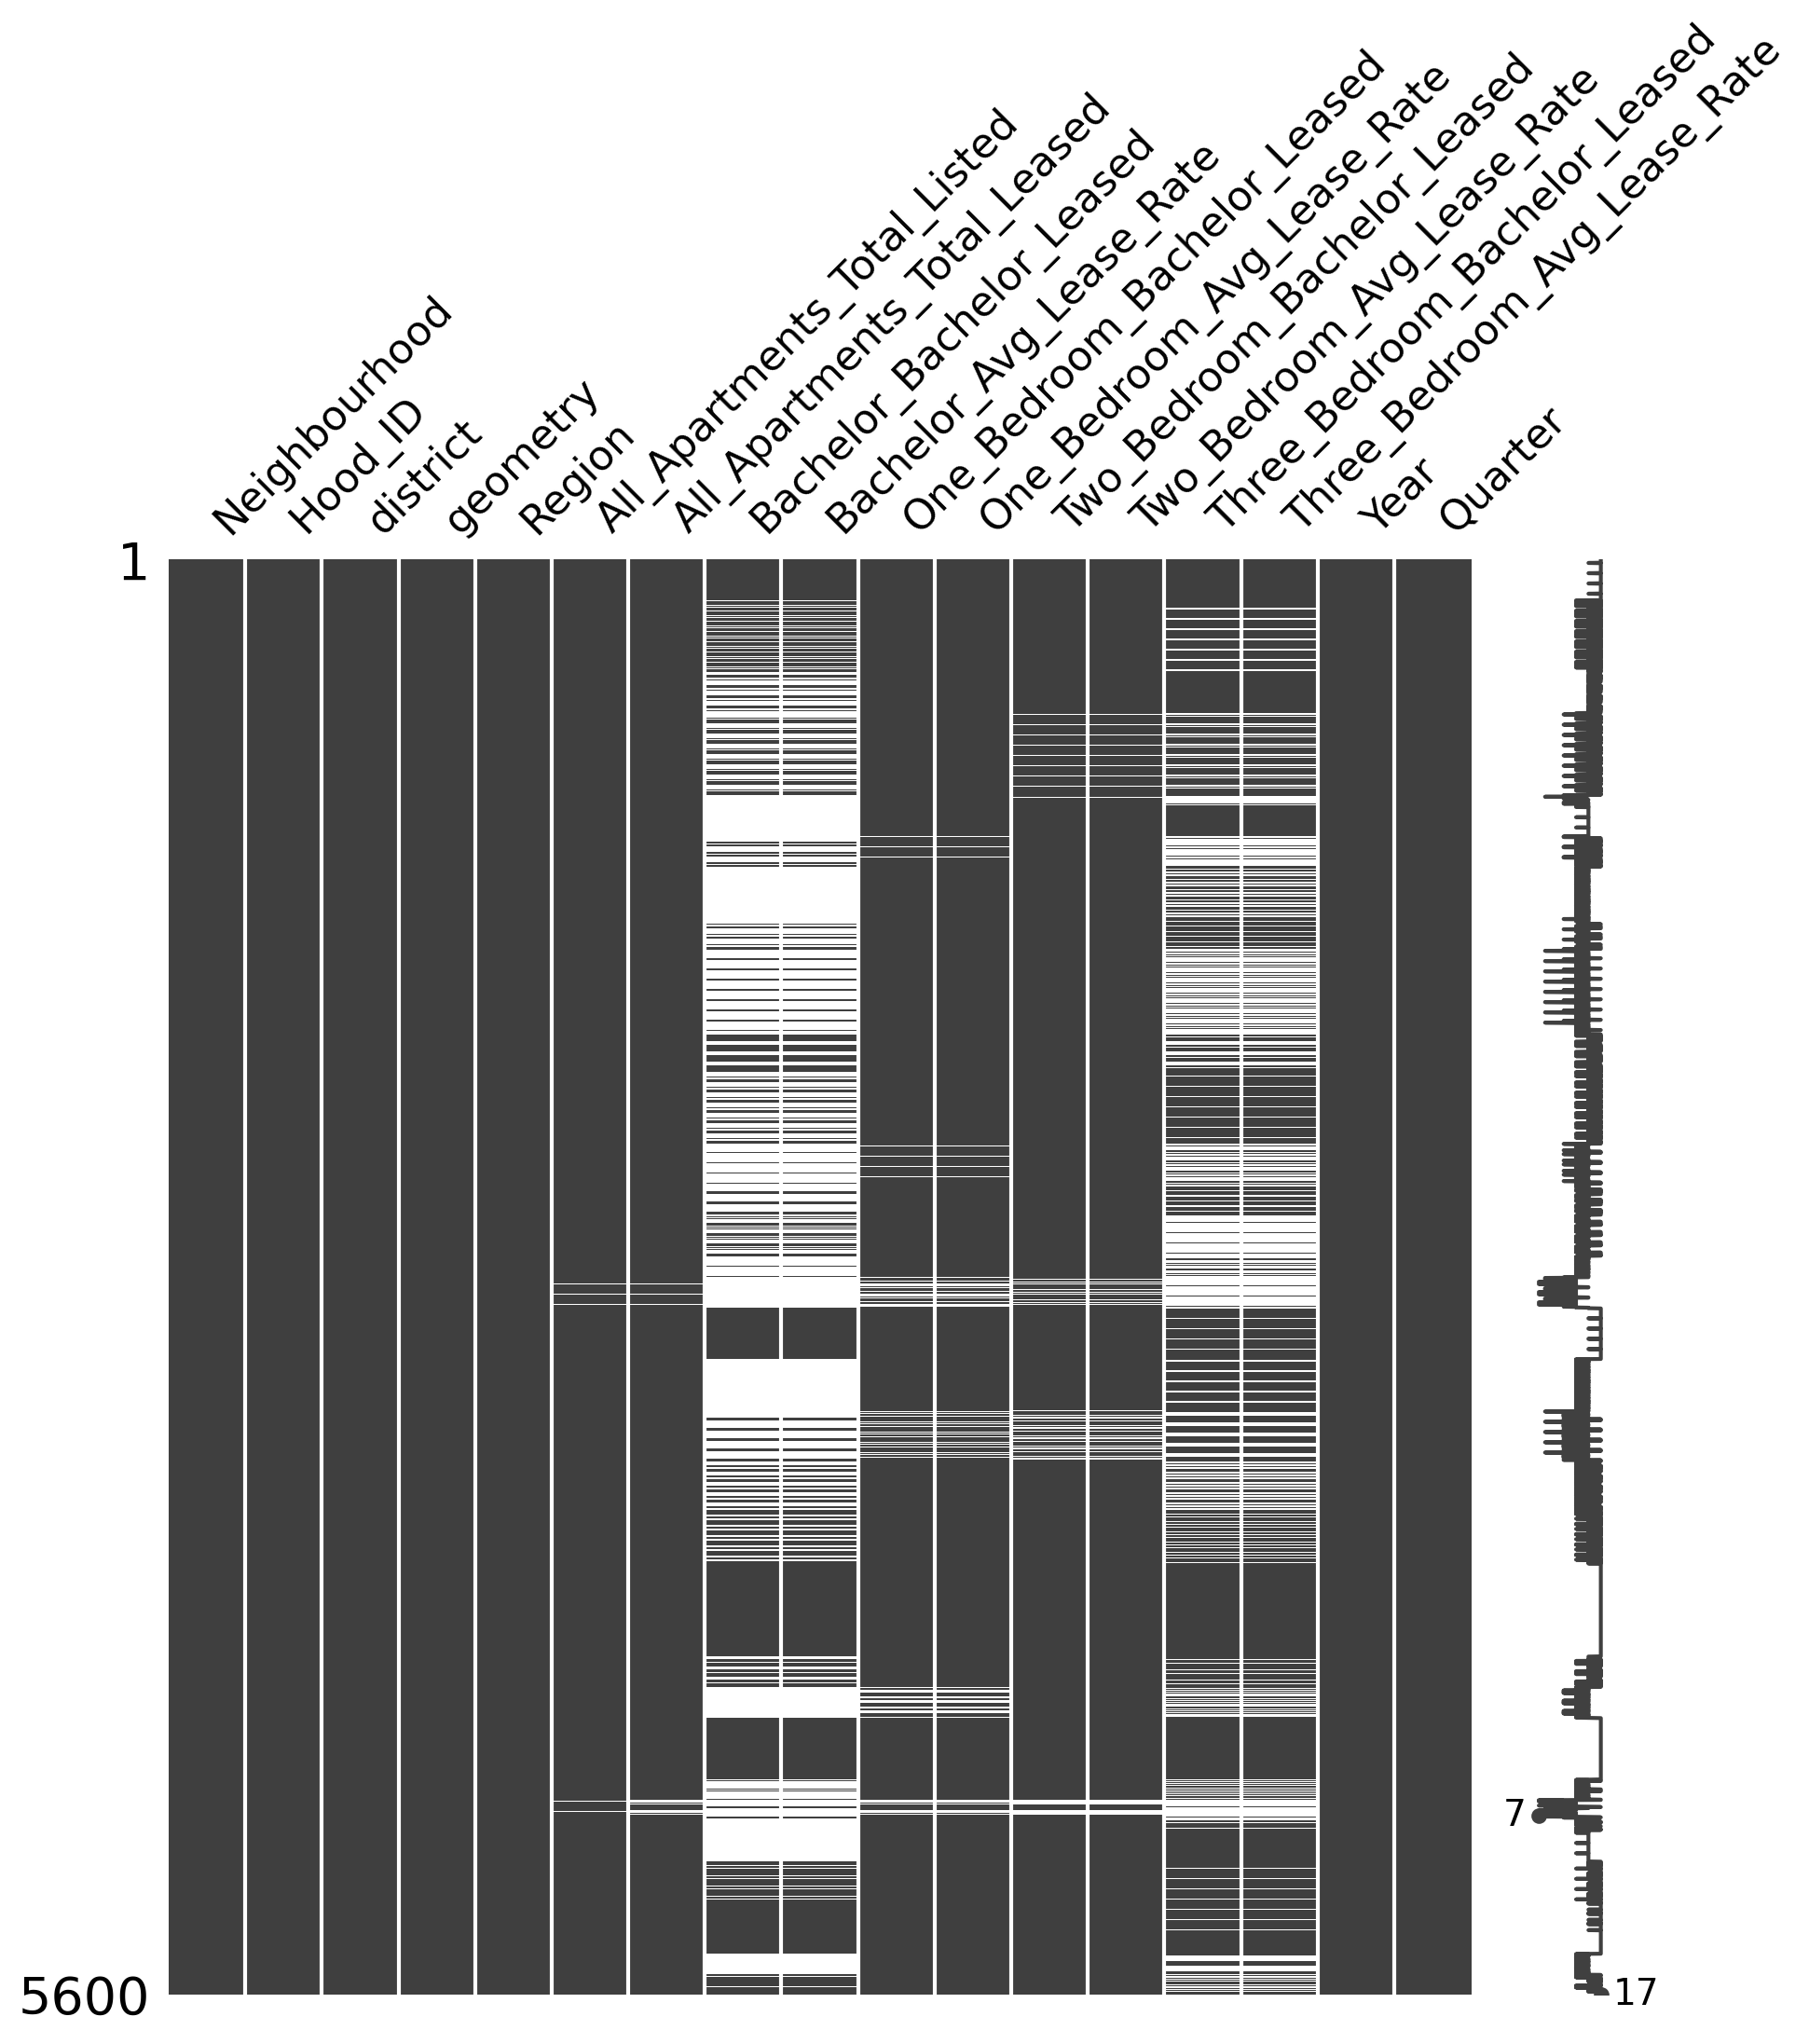

In [30]:
msno.matrix(neighborhoods_rental, figsize=(10,10))

In [31]:
neighborhoods_rental[neighborhoods_rental.isna().sum(axis=1) != 0].head()

Neighbourhood Hood_ID district  \
14            Yonge-St.Clair      97      C02   
54                 Casa Loma      96      C02   
94                     Annex      95      C02   
134                 Wychwood      94      C02   
160  York University Heights      27      W05   

                                              geometry Region  \
14   POLYGON ((-79.39115 43.68108, -79.39137 43.680...    C02   
54   POLYGON ((-79.41465 43.67391, -79.41481 43.674...    C02   
94   POLYGON ((-79.39410 43.66872, -79.39584 43.668...    C02   
134  POLYGON ((-79.43588 43.68015, -79.43488 43.680...    C02   
160  POLYGON ((-79.50525 43.75987, -79.50484 43.759...    W05   

     All_Apartments_Total_Listed  All_Apartments_Total_Leased  \
14                         626.0                        343.0   
54                         626.0                        343.0   
94                         626.0                        343.0   
134                        626.0                        343.0   
160                         43.0                         17.0   

     Bachelor_Bachelor_Leased  Bachelor_Avg_Lease_Rate  \
14                       21.0                   1407.0   
54                       21.0                   1407.0   
94                       21.0                   1407.0   
134                      21.0                   1407.0   
160                       NaN                      NaN   

     One_Bedroom_Bachelor_Leased  One_Bedroom_Avg_Lease_Rate  \
14                         207.0                      1975.0   
54                         207.0                      1975.0   
94                         207.0                      1975.0   
134                        207.0                      1975.0   
160                         12.0                      1354.0   

     Two_Bedroom_Bachelor_Leased  Two_Bedroom_Avg_Lease_Rate  \
14                         115.0                      3405.0   
54                         115.0                      3405.0   
94                         115.0                      3405.0   
134                        115.0                      3405.0   
160                          5.0                      1578.0   

     Three_Bedroom_Bachelor_Leased  Three_Bedroom_Avg_Lease_Rate  Year  \
14                             NaN                           NaN  2015   
54                             NaN                           NaN  2015   
94                             NaN                           NaN  2015   
134                            NaN                           NaN  2015   
160                            NaN                           NaN  2012   

     Quarter  
14         3  
54         3  
94         3  
134        3  
160        1

In [32]:
# row 14 is the row with NA
neighborhoods_rental.iloc[13:16, 4:]

Region  All_Apartments_Total_Listed  All_Apartments_Total_Leased  \
13    C02                        589.0                        217.0   
14    C02                        626.0                        343.0   
15    C02                        374.0                        141.0   

    Bachelor_Bachelor_Leased  Bachelor_Avg_Lease_Rate  \
13                       9.0                   1457.0   
14                      21.0                   1407.0   
15                       9.0                   1489.0   

    One_Bedroom_Bachelor_Leased  One_Bedroom_Avg_Lease_Rate  \
13                        122.0                      1779.0   
14                        207.0                      1975.0   
15                         70.0                      1981.0   

    Two_Bedroom_Bachelor_Leased  Two_Bedroom_Avg_Lease_Rate  \
13                         84.0                      4394.0   
14                        115.0                      3405.0   
15                         60.0                      3697.0   

    Three_Bedroom_Bachelor_Leased  Three_Bedroom_Avg_Lease_Rate  Year  Quarter  
13                            2.0                        4900.0  2015        2  
14                            NaN                           NaN  2015        3  
15                            2.0                        8750.0  2015        4

In [33]:
neighborhoods_rental.iloc[13:16,4:].ffill(axis=0)

Region  All_Apartments_Total_Listed  All_Apartments_Total_Leased  \
13    C02                        589.0                        217.0   
14    C02                        626.0                        343.0   
15    C02                        374.0                        141.0   

    Bachelor_Bachelor_Leased  Bachelor_Avg_Lease_Rate  \
13                       9.0                   1457.0   
14                      21.0                   1407.0   
15                       9.0                   1489.0   

    One_Bedroom_Bachelor_Leased  One_Bedroom_Avg_Lease_Rate  \
13                        122.0                      1779.0   
14                        207.0                      1975.0   
15                         70.0                      1981.0   

    Two_Bedroom_Bachelor_Leased  Two_Bedroom_Avg_Lease_Rate  \
13                         84.0                      4394.0   
14                        115.0                      3405.0   
15                         60.0                      3697.0   

    Three_Bedroom_Bachelor_Leased  Three_Bedroom_Avg_Lease_Rate  Year  Quarter  
13                            2.0                        4900.0  2015        2  
14                            2.0                        4900.0  2015        3  
15                            2.0                        8750.0  2015        4

In [34]:
# if we don't have rental transactions in this quarter, we use the number from the last quarter
# forward fillna for the columns other than the first 4 columns (Neighbourhood, Hood_ID, district, geometry)
neighborhoods_rental.iloc[:,4:] = neighborhoods_rental.iloc[:,4:].ffill(axis=0).values

In [50]:
neighborhoods_rental['One_Bedroom_Avg_Lease_Rate'].min(), neighborhoods_rental['One_Bedroom_Avg_Lease_Rate'].max()

(850.0, 2878.0)

In [61]:
rental_years = neighborhoods_rental.Year.unique()
rental_quarters = neighborhoods_rental.Quarter.unique()
def plot_rental(var, title):
    fig, axes = plt.subplots(len(rental_quarters), len(rental_years))
    
    for j in range(axes.shape[1]):
        
        # due to inflation, rental rates in recent years must be higher than those in previous years
        # therefore, it would only make sense to fix the range for the colorbar 
        # such that we compare across quarters to observe seasonal effect (if any) in each year, but not across years
        selected_period = neighborhoods_rental.loc[(neighborhoods_rental['Year'] == rental_years[j])]
        vmin, vmax = selected_period[var].min(), selected_period[var].max()
        norm = TwoSlopeNorm(vmin=vmin, vcenter= np.mean([vmin, vmax]), vmax=vmax)    
        
        for i in range(axes.shape[0]):         
            plot_df = neighborhoods_rental.loc[(neighborhoods_rental['Quarter'] == rental_quarters[i]) & (neighborhoods_rental['Year'] == rental_years[j])]
            plot_df.plot(column = var, cmap = 'viridis', norm = norm, ax = axes[i, j])
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].set_yticks([])
            if i == 0:
                axes[i,j].set_title(rental_years[j])
            if j == 0:
                axes[i,j].set_ylabel("Q" + str(rental_quarters[i]), rotation=90, size='large')

    fig.suptitle(title, size='xx-large')

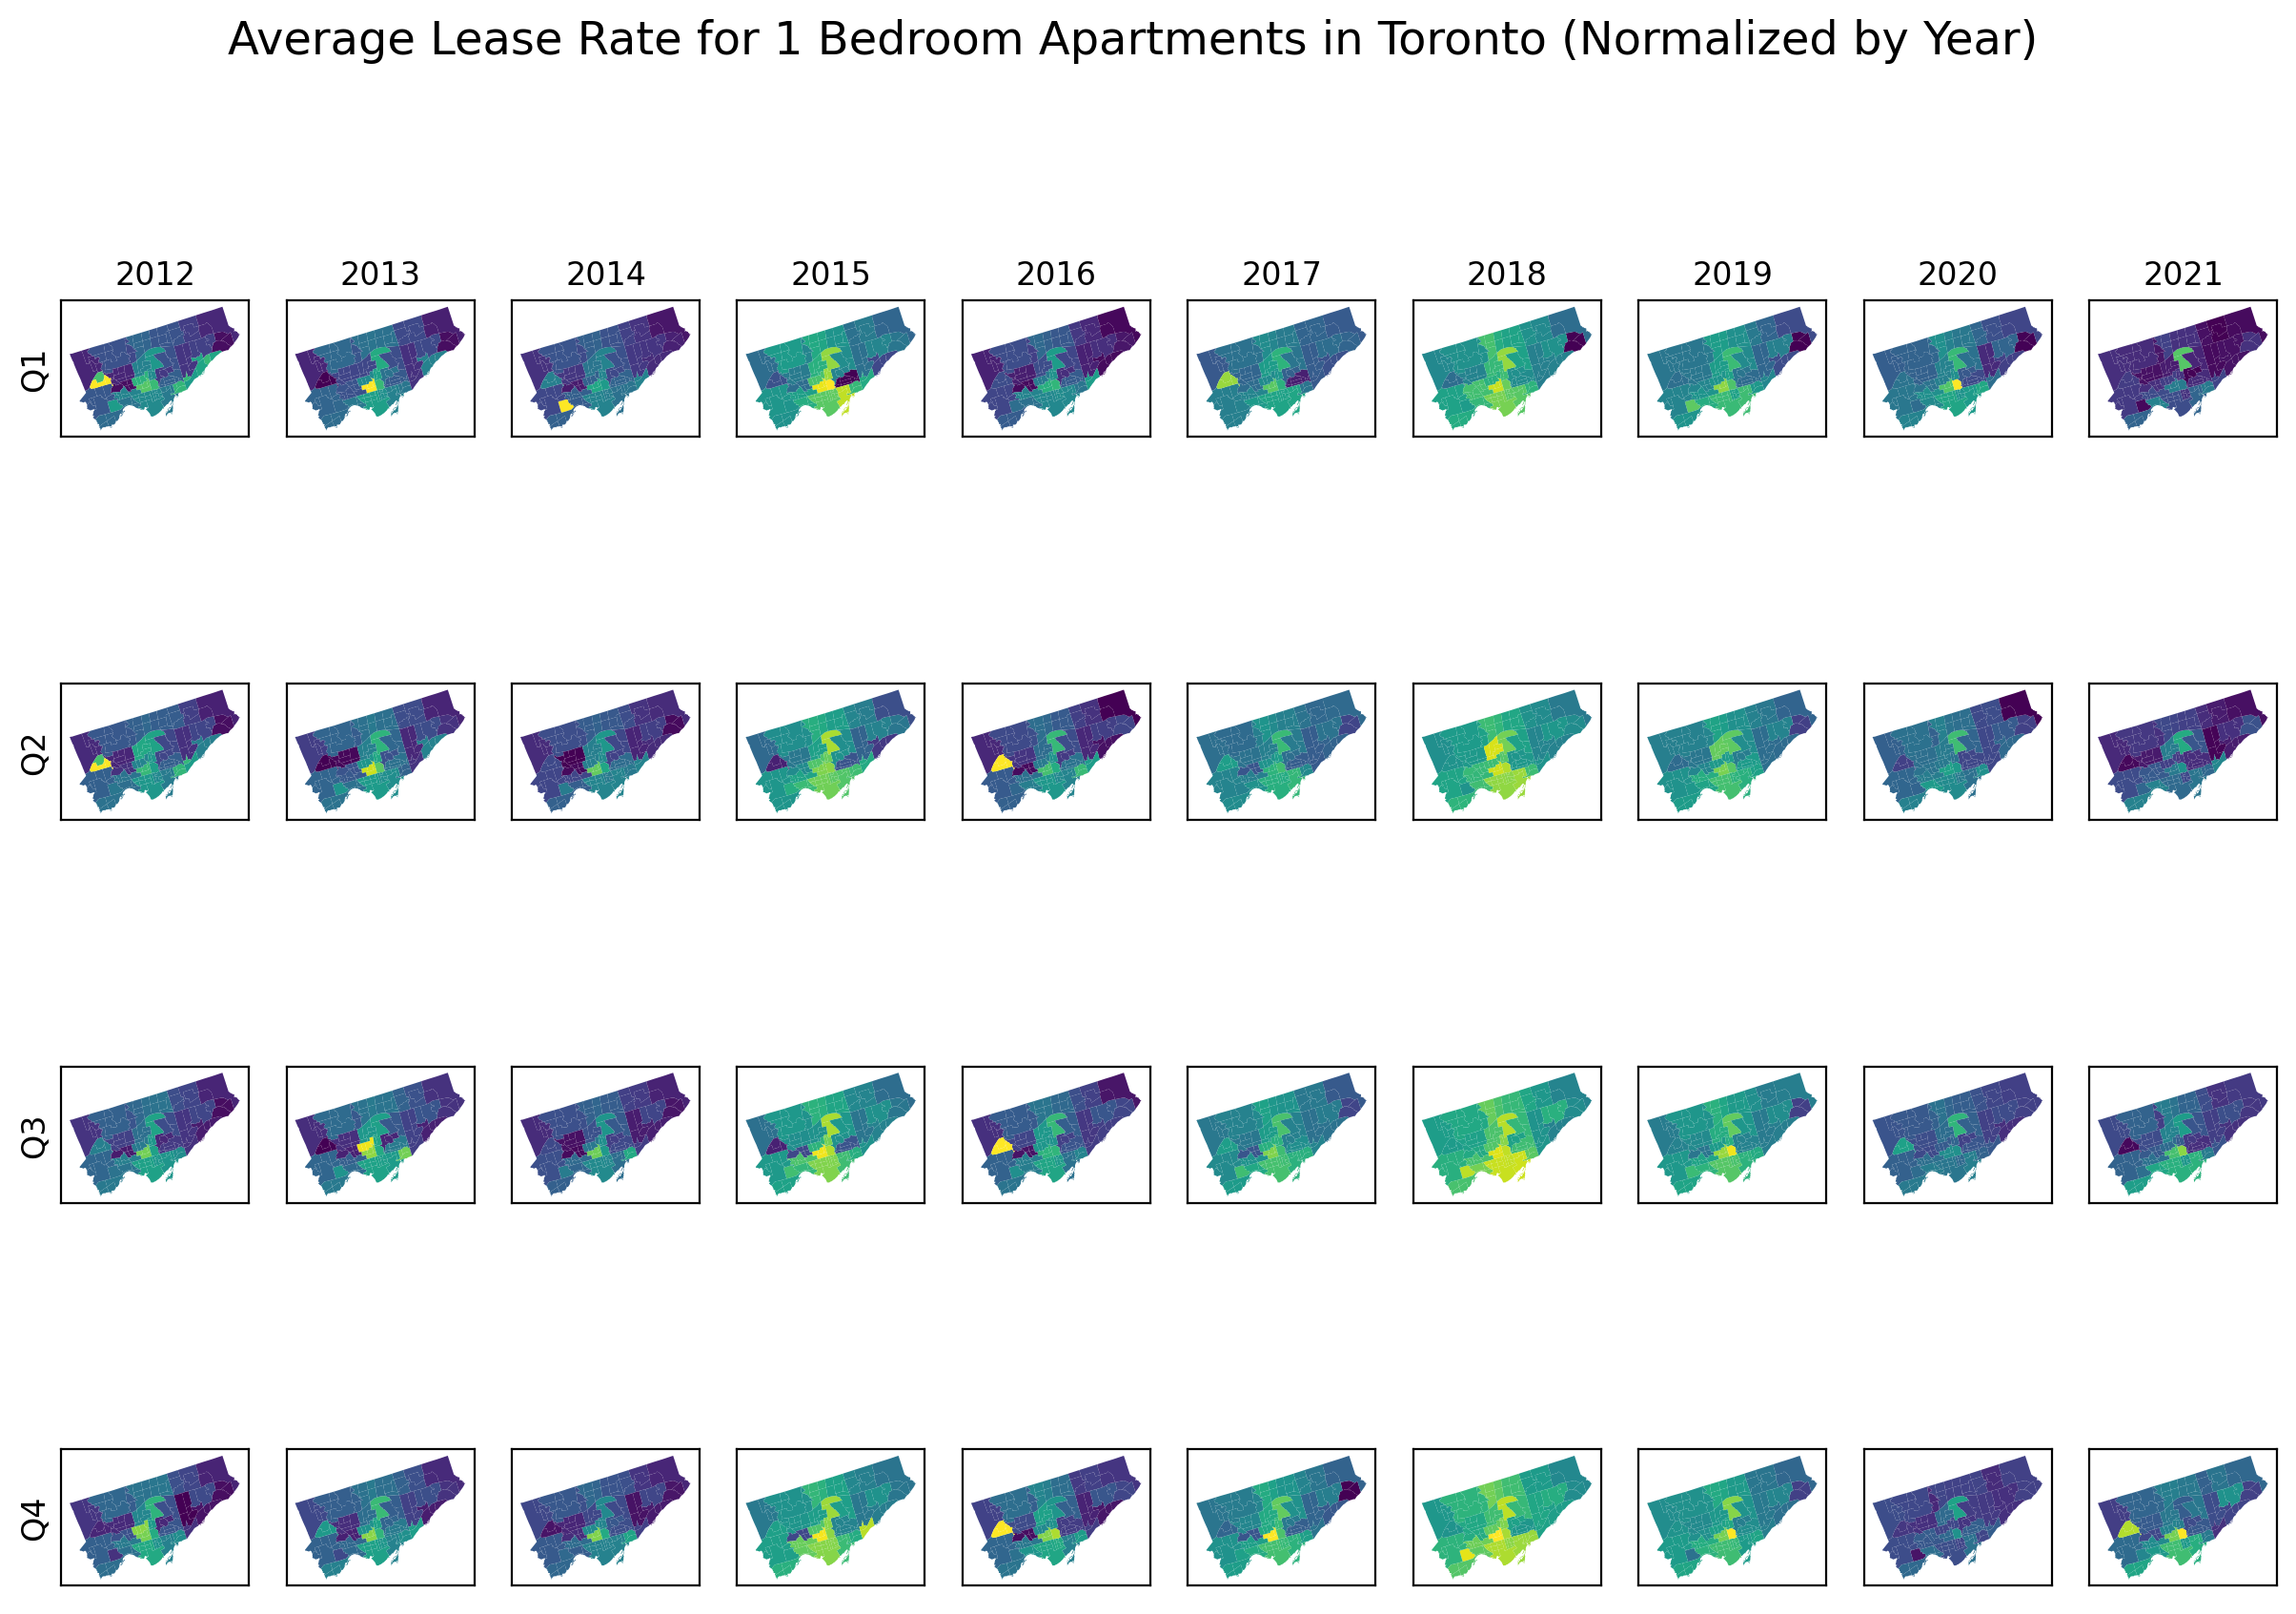

In [62]:
plot_rental('One_Bedroom_Avg_Lease_Rate', 'Average Lease Rate for 1 Bedroom Apartments in Toronto (Normalized by Year)')

In [82]:
selected_year = 2021
selected_quarter = 1
var = 'One_Bedroom_Avg_Lease_Rate'

Text(0.5, 1.0, 'One_Bedroom_Avg_Lease_Rate Max: $2,275, $Average: 1,790, Min: $1,650, IQR: $113')

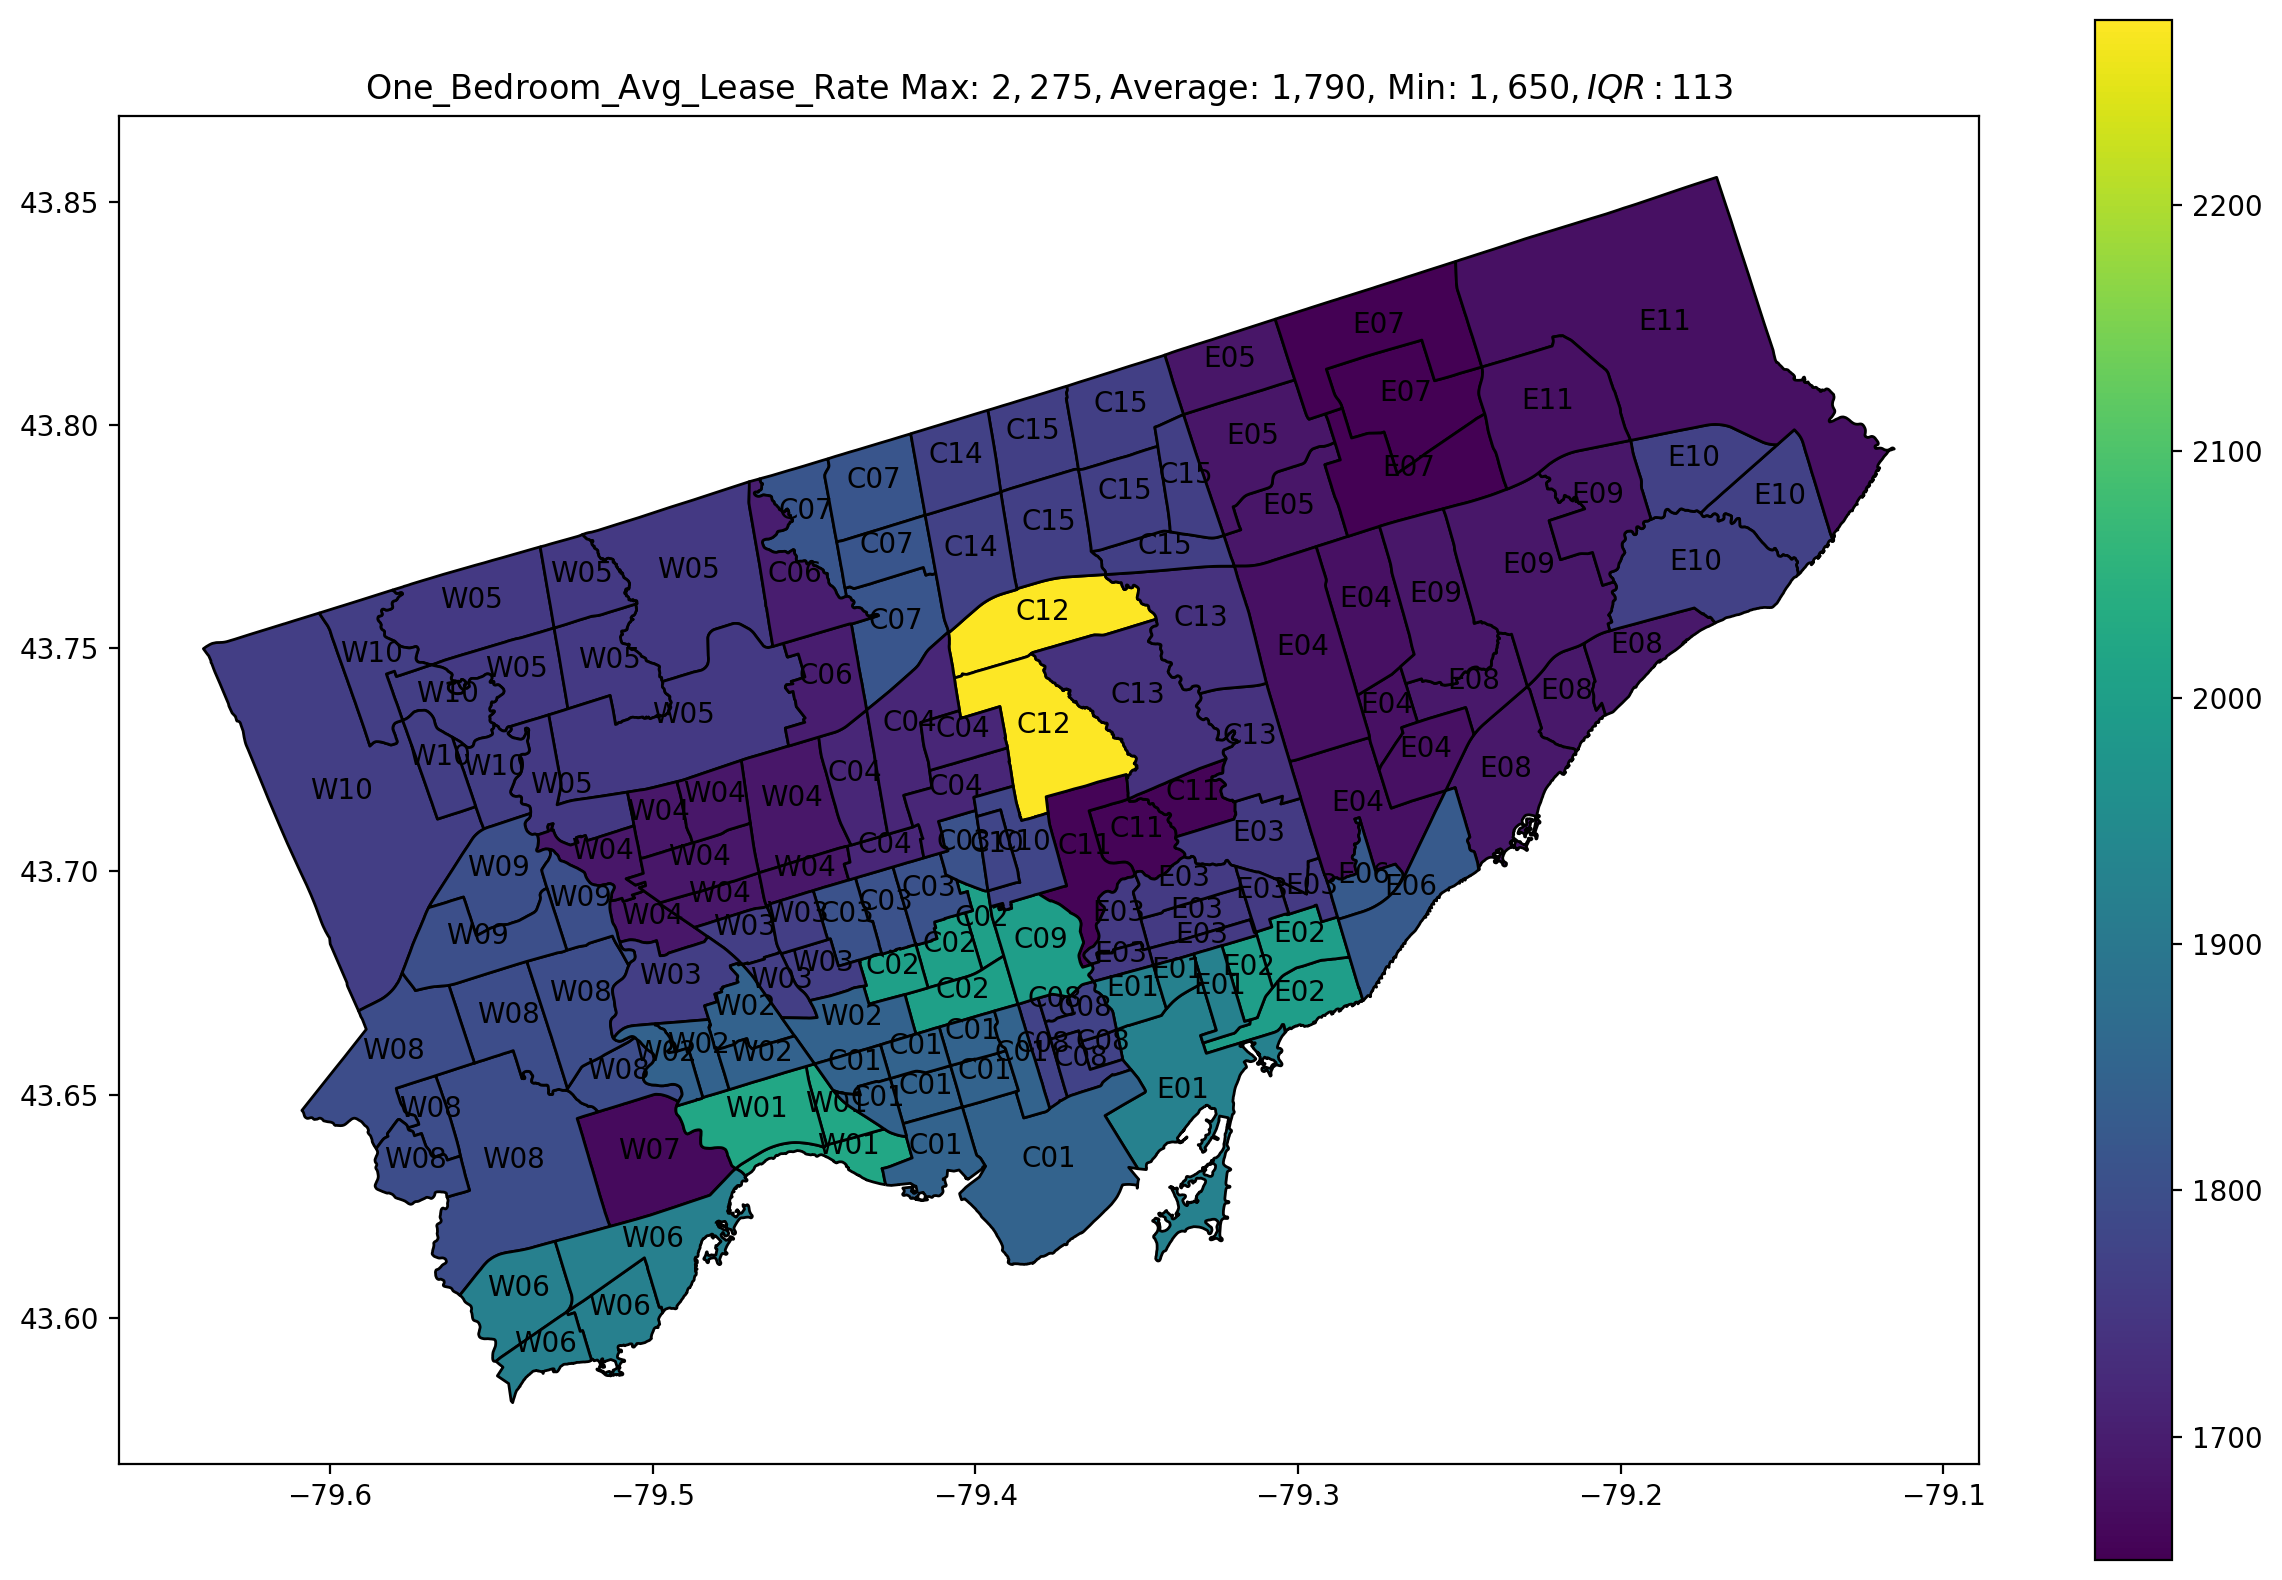

In [83]:
selected_period = neighborhoods_rental.loc[(neighborhoods_rental['Year'] == selected_year) & (neighborhoods_rental['Quarter'] == selected_quarter)]
ax = selected_period.plot(column = var, 
                     legend = True,
                     edgecolor = 'black',
                     cmap = "viridis")
for geometry, label in zip(selected_period.geometry, selected_period.district):
    ax.annotate(label, xy=(geometry.centroid.x, geometry.centroid.y), ha='center')
    
ax.set_title(f"{var} Max: ${selected_period[var].max():,.0f}, $Average: {selected_period[var].mean():,.0f}, Min: ${selected_period[var].min():,.0f}, IQR: ${selected_period[var].quantile(0.75) - selected_period[var].quantile(0.25):,.0f}")

In [79]:
neighborhoods_rental.loc[(neighborhoods_rental['Year'] == selected_year) & (neighborhoods_rental['Quarter'] == selected_quarter)].groupby('district')['One_Bedroom_Avg_Lease_Rate'].mean().sort_values(ascending=False)

district
C02    2386.0
C12    2260.0
C01    2189.0
C09    2155.0
C08    2107.0
E01    2106.0
W03    2050.0
C07    2050.0
W02    2034.0
C10    2019.0
C04    1996.0
W01    1987.0
E02    1958.0
C03    1937.0
C14    1921.0
W06    1906.0
C15    1856.0
W08    1845.0
C13    1836.0
W07    1800.0
C06    1739.0
E09    1735.0
E05    1733.0
W05    1730.0
C11    1726.0
E03    1700.0
E07    1681.0
W10    1675.0
W04    1648.0
E08    1638.0
E04    1621.0
E06    1608.0
E11    1500.0
W09    1500.0
E10     950.0
Name: One_Bedroom_Avg_Lease_Rate, dtype: float64

In [84]:
neighborhoods[neighborhoods['district'] == 'E10']

OBJECTID           Neighbourhood Hood_ID  F2020_Population_Projection  \
21        22  Centennial Scarborough     133                        14672   
40        41               West Hill     136                        29669   
71        72          Highland Creek     134                        13943   

    Assault_2014  Assault_2015  Assault_2016  Assault_2017  Assault_2018  \
21            52            38            49            47            46   
40           347           395           422           412           425   
71            52            50            73            68            50   

    Assault_2019  ...  All_Rate2018  All_Density2018  All_2019  \
21            49  ...    563.182012        14.629383       103   
40           445  ...   2299.162480        64.205415       653   
71            64  ...    835.509152        21.341712       141   

    Population_2019  All_Rate2019  All_Density2019  All_2020  Population_2020  \
21     14436.999938    713.444625        18.835331        69     14671.999662   
40     29308.998798   2227.984670        67.841644       501     29668.999456   
71     13694.000034   1029.648018        26.867691        68     13942.998521   

    All_Rate2020  All_Density2020  
21    470.283544        12.617843  
40   1688.631262        52.050021  
71    487.699973        12.957468  

[3 rows x 183 columns]

# Import major crime indicators

In [40]:
# geojson format is too big -> use csv instead
mci_point = pd.read_csv('./clean_data/mci_point.csv')
mci_point['geometry'] = mci_point.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)
mci_point = gpd.GeoDataFrame(mci_point, crs='epsg:' + str(epsg_3d), geometry='geometry')

C:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [41]:
mci_point

X             Y  Index_ event_unique_id Division  \
0      -8.854229e+06  5.425760e+06       1  GO-20141624853      D31   
1      -8.834951e+06  5.412259e+06       2  GO-20141625057      D51   
2      -8.825836e+06  5.417935e+06       3  GO-20141259602      D41   
3      -8.847703e+06  5.416571e+06       4  GO-20141260128      D12   
4      -8.837275e+06  5.411569e+06       5  GO-20141259483      D52   
...              ...           ...     ...             ...      ...   
259618 -8.835231e+06  5.421552e+06  262198   GO-2021995584      D53   
259619 -8.849750e+06  5.417652e+06  262199   GO-2021994271      D12   
259620 -8.849750e+06  5.417652e+06  262200   GO-2021994271      D12   
259621 -8.834998e+06  5.421758e+06  262201   GO-2021994920      D53   
259622 -8.835737e+06  5.421780e+06  262202   GO-2021995141      D53   

                   occurrencedate            reporteddate premisetype  \
0       2014-03-02 05:00:00+00:00  2014/03/02 05:00:00+00   Apartment   
1       2014-03-02 05:00:00+00:00  2014/03/02 05:00:00+00  Commercial   
2       2013-12-31 05:00:00+00:00  2014/01/01 05:00:00+00  Commercial   
3       2014-01-01 05:00:00+00:00  2014/01/01 05:00:00+00       House   
4       2013-12-31 05:00:00+00:00  2014/01/01 05:00:00+00     Transit   
...                           ...                     ...         ...   
259618  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00       House   
259619  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00     Outside   
259620  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00     Outside   
259621  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00       House   
259622  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00     Outside   

        ucr_code  ucr_ext  ... occurrencedayofyear  occurrencedayofweek  \
0           1430      100  ...                61.0           Sunday       
1           2120      200  ...                61.0           Sunday       
2           2120      220  ...               365.0           Tuesday      
3           1430      100  ...                 1.0           Wednesday    
4           1430      100  ...               365.0           Tuesday      
...          ...      ...  ...                 ...                  ...   
259618      2135      210  ...               149.0           Saturday     
259619      2135      210  ...               149.0           Saturday     
259620      2135      210  ...               149.0           Saturday     
259621      2135      210  ...               149.0           Saturday     
259622      2135      210  ...               149.0           Saturday     

       occurrencehour              MCI  Hood_ID        Neighbourhood  \
0                   5          Assault       22           Humbermede   
1                   4  Break and Enter       73            Moss Park   
2                  23  Break and Enter      121             Oakridge   
3                   1          Assault      111    Rockcliffe-Smythe   
4                  21          Assault       76  Bay Street Corridor   
...               ...              ...      ...                  ...   
259618              2       Auto Theft       56   Leaside-Bennington   
259619              0       Auto Theft      115         Mount Dennis   
259620              0       Auto Theft      115         Mount Dennis   
259621              2       Auto Theft       56   Leaside-Bennington   
259622              3       Auto Theft       56   Leaside-Bennington   

             Long        Lat ObjectId                    geometry  
0      -79.538894  43.743025        1  POINT (-79.53889 43.74302)  
1      -79.365716  43.655340        2  POINT (-79.36572 43.65534)  
2      -79.283837  43.692217        3  POINT (-79.28384 43.69222)  
3      -79.480268  43.683360        4  POINT (-79.48027 43.68336)  
4      -79.386589  43.650853        5  POINT (-79.38659 43.65085)  
...           ...        ...      ...                         ...  
259618 -79.368232  43.715704   262703  POINT (-

# Import traffic collisions

In [42]:
# geojson format is too big -> use csv instead
collision_point = pd.read_csv('./clean_data/collision_point.csv')
collision_point['geometry'] = collision_point.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)
collision_point = gpd.GeoDataFrame(collision_point, crs='epsg:' + str(epsg_3d), geometry='geometry')

C:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [43]:
collision_point

X             Y  OBJECTID   EventUniqueId  \
0       0.000000e+00  0.000000e+00       278  GO-20141591056   
1       0.000000e+00  0.000000e+00      1246  GO-20143120578   
2       0.000000e+00  0.000000e+00     21564  GO-20168056919   
3       0.000000e+00  0.000000e+00     21709  GO-20168059092   
4       0.000000e+00  0.000000e+00     21277  GO-20168053844   
...              ...           ...       ...             ...   
430281 -8.865398e+06  5.426816e+06    499212  GO-20178006796   
430282 -8.865398e+06  5.426816e+06    499213  GO-20178007507   
430283 -8.865398e+06  5.426816e+06    499214  GO-20178008123   
430284 -8.865398e+06  5.426816e+06    499215  GO-20178014940   
430285 -8.865398e+06  5.426816e+06    499216  GO-20178020054   

                OccurrenceDate     Month Day_of_Week  Year  Hour Division  \
0       2014/02/24 05:00:00+00  February      Monday  2014    17      D32   
1       2014/10/17 04:00:00+00   October      Friday  2014     9      D31   
2       2016/12/17 05:00:00+00  December    Saturday  2016     9      D31   
3       2016/12/27 05:00:00+00  December     Tuesday  2016    18      D32   
4       2016/11/30 05:00:00+00  November   Wednesday  2016    18      D33   
...                        ...       ...         ...   ...   ...      ...   
430281  2017/02/14 05:00:00+00  February     Tuesday  2017    14      NSA   
430282  2017/02/18 05:00:00+00  February    Saturday  2017    13      NSA   
430283  2017/02/22 05:00:00+00  February   Wednesday  2017    22      D23   
430284  2017/04/07 04:00:00+00     April      Friday  2017    14      NSA   
430285  2017/05/07 04:00:00+00       May      Sunday  2017    16      NSA   

        ...             Neighbourhood Fatalities  Injury_Collisions  \
0       ...     St.Andrew-Windfields           0                 NO   
1       ...   Glenfield-Jane Heights           0                 NO   
2       ...  York University Heights           0                 NO   
3       ...       Yorkdale-Glen Park           0                 NO   
4       ...        Hillcrest Village           0                 NO   
...     ...                       ...        ...                ...   
430281  ...                       NSA          0                 NO   
430282  ...                       NSA          0                 NO   
430283  ...   West Humber-Clairville           0                 NO   
430284  ...                       NSA          0                 NO   
430285  ...                       NSA          0                 NO   

       FTR_Collisions PD_Collisions       Long        Lat  ObjectId2  Hood_ID  \
0                 YES            NO -79.402034  43.748097        178       40   
1                  NO           YES -79.513544  43.743014       1046       25   
2                  NO           YES -79.498253  43.763907      21094       27   
3                 YES            NO -79.459962  43.707040      21162       31   
4                  NO           YES -79.352088  43.807805      21340       48   
...               ...           ...        ...        ...        ...      ...   
430281             NO           YES -79.639225  43.749873     499534      NSA   
430282            YES            NO -79.639225  43.749873     499535      NSA   
430283             NO           YES -79.639225  43.749873     499536        1   
430284             NO           YES -79.639225  43.749873     499537      NSA   
430285             NO           YES -79.639225  43.749873     499538      NSA   

                          geometry  
0       POINT (-79.40203 43.74810)  
1       POINT (-79.51354 43.74301)  
2       POINT (-79.49825 43.76391)  
3       POINT (-79.45996 43.70704)  
4       POINT (-79.35209 43.80780)  
...                            ...  
430281  POINT (-79.63923 43.74987)  
430282  POINT (-79.63923 43.74987)  
430283  POINT (-79.63923 43.74987)  
430284  POINT (-79.63923 43.74987)  
430285  POINT (-79.63923 43.74987)  

[430286 rows x 21 columns]

# Crime around subway stations

In [44]:
crime_around_stations = gpd.sjoin(mci_point, stations_area, op='intersects')
crime_around_stations

C:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



X             Y  Index_ event_unique_id Division  \
4      -8.837275e+06  5.411569e+06       5  GO-20141259483      D52   
61     -8.836874e+06  5.410915e+06      66  GO-20141262372      D52   
583    -8.836993e+06  5.410881e+06     795  GO-20141328312      D52   
663    -8.837155e+06  5.411264e+06     976  GO-20141343564      D52   
926    -8.836833e+06  5.411571e+06     247  GO-20141274610      D52   
...              ...           ...     ...             ...      ...   
202539 -8.851130e+06  5.431108e+06  205396  GO-20201490510      D31   
211149 -8.851130e+06  5.431108e+06  213747  GO-20202193214      D31   
214977 -8.851130e+06  5.431108e+06  217867   GO-2021101646      D31   
225937 -8.851130e+06  5.431108e+06  228998  GO-20211136719      D31   
230404 -8.853438e+06  5.433740e+06  233332  GO-20143349474      NSA   

                   occurrencedate            reporteddate premisetype  \
4       2013-12-31 05:00:00+00:00  2014/01/01 05:00:00+00     Transit   
61      2014-01-01 05:00:00+00:00  2014/01/01 05:00:00+00  Commercial   
583     2014-01-12 05:00:00+00:00  2014/01/12 05:00:00+00       Other   
663     2014-01-12 05:00:00+00:00  2014/01/14 05:00:00+00   Apartment   
926     2014-01-03 05:00:00+00:00  2014/01/03 05:00:00+00  Commercial   
...                           ...                     ...         ...   
202539  2020-08-09 04:00:00+00:00  2020/08/09 04:00:00+00  Commercial   
211149  2020-11-19 05:00:00+00:00  2020/11/19 05:00:00+00     Outside   
214977  2021-01-17 05:00:00+00:00  2021/01/17 05:00:00+00     Outside   
225937  2021-06-17 04:00:00+00:00  2021/06/17 04:00:00+00     Transit   
230404  2014-11-08 05:00:00+00:00  2014/11/22 05:00:00+00     Outside   

        ucr_code  ucr_ext  ... distance_km_order  commute_time_order  \
4           1430      100  ...                17                   8   
61          2120      200  ...                17                   8   
583         1430      100  ...                17                   8   
663         2130      210  ...                17                   8   
926         2130      210  ...                17                   8   
...          ...      ...  ...               ...                 ...   
202539      1430      100  ...                70                  61   
211149      1430      100  ...                70                  61   
214977      1430      100  ...                70                  61   
225937      1420      110  ...                70                  61   
230404      2135      210  ...                74                  64   

                                                      url  \
4       https://www.ttc.ca/subway-stations/st-andrew-s...   
61      https://www.ttc.ca/subway-stations/st-andrew-s...   
583     https://www.ttc.ca/subway-stations/st-andrew-s...   
663     https://www.ttc.ca/subway-stations/st-andrew-s...   
926     https://www.ttc.ca/subway-stations/st-andrew-s...   
...                                                   ...   
202539  https://www.ttc.ca/subway-stations/pioneer-vil...   
211149  https://www.ttc.ca/subway-stations/pioneer-vil...   
214977  https://www.ttc.ca/subway-stations/pioneer-vil...   
225937  https://www.ttc.ca/subway-stations/pioneer-vil...   
230404  https://www.ttc.ca/subway-stations/vaughan-met...   

                            station                     line order  longitude  \
4                         st andrew  Line 1 Yonge-University    17 -79.384808   
61                        st andrew  Line 1 Yonge-University    17 -79.384808   
583                       st andrew  Line 1 Yonge-University    17 -79.384808   
663                       st andrew  Line 1 Yonge-University    17 -79.384808   
926                       st andrew  Line 1 Yonge-University    17 -79.384808   
...                             ...                      ...   ...        ...   
202539              pioneer village  Line 1 Yonge-University    35 -79.510329   
211149              pioneer village  Line 1

<AxesSubplot:>

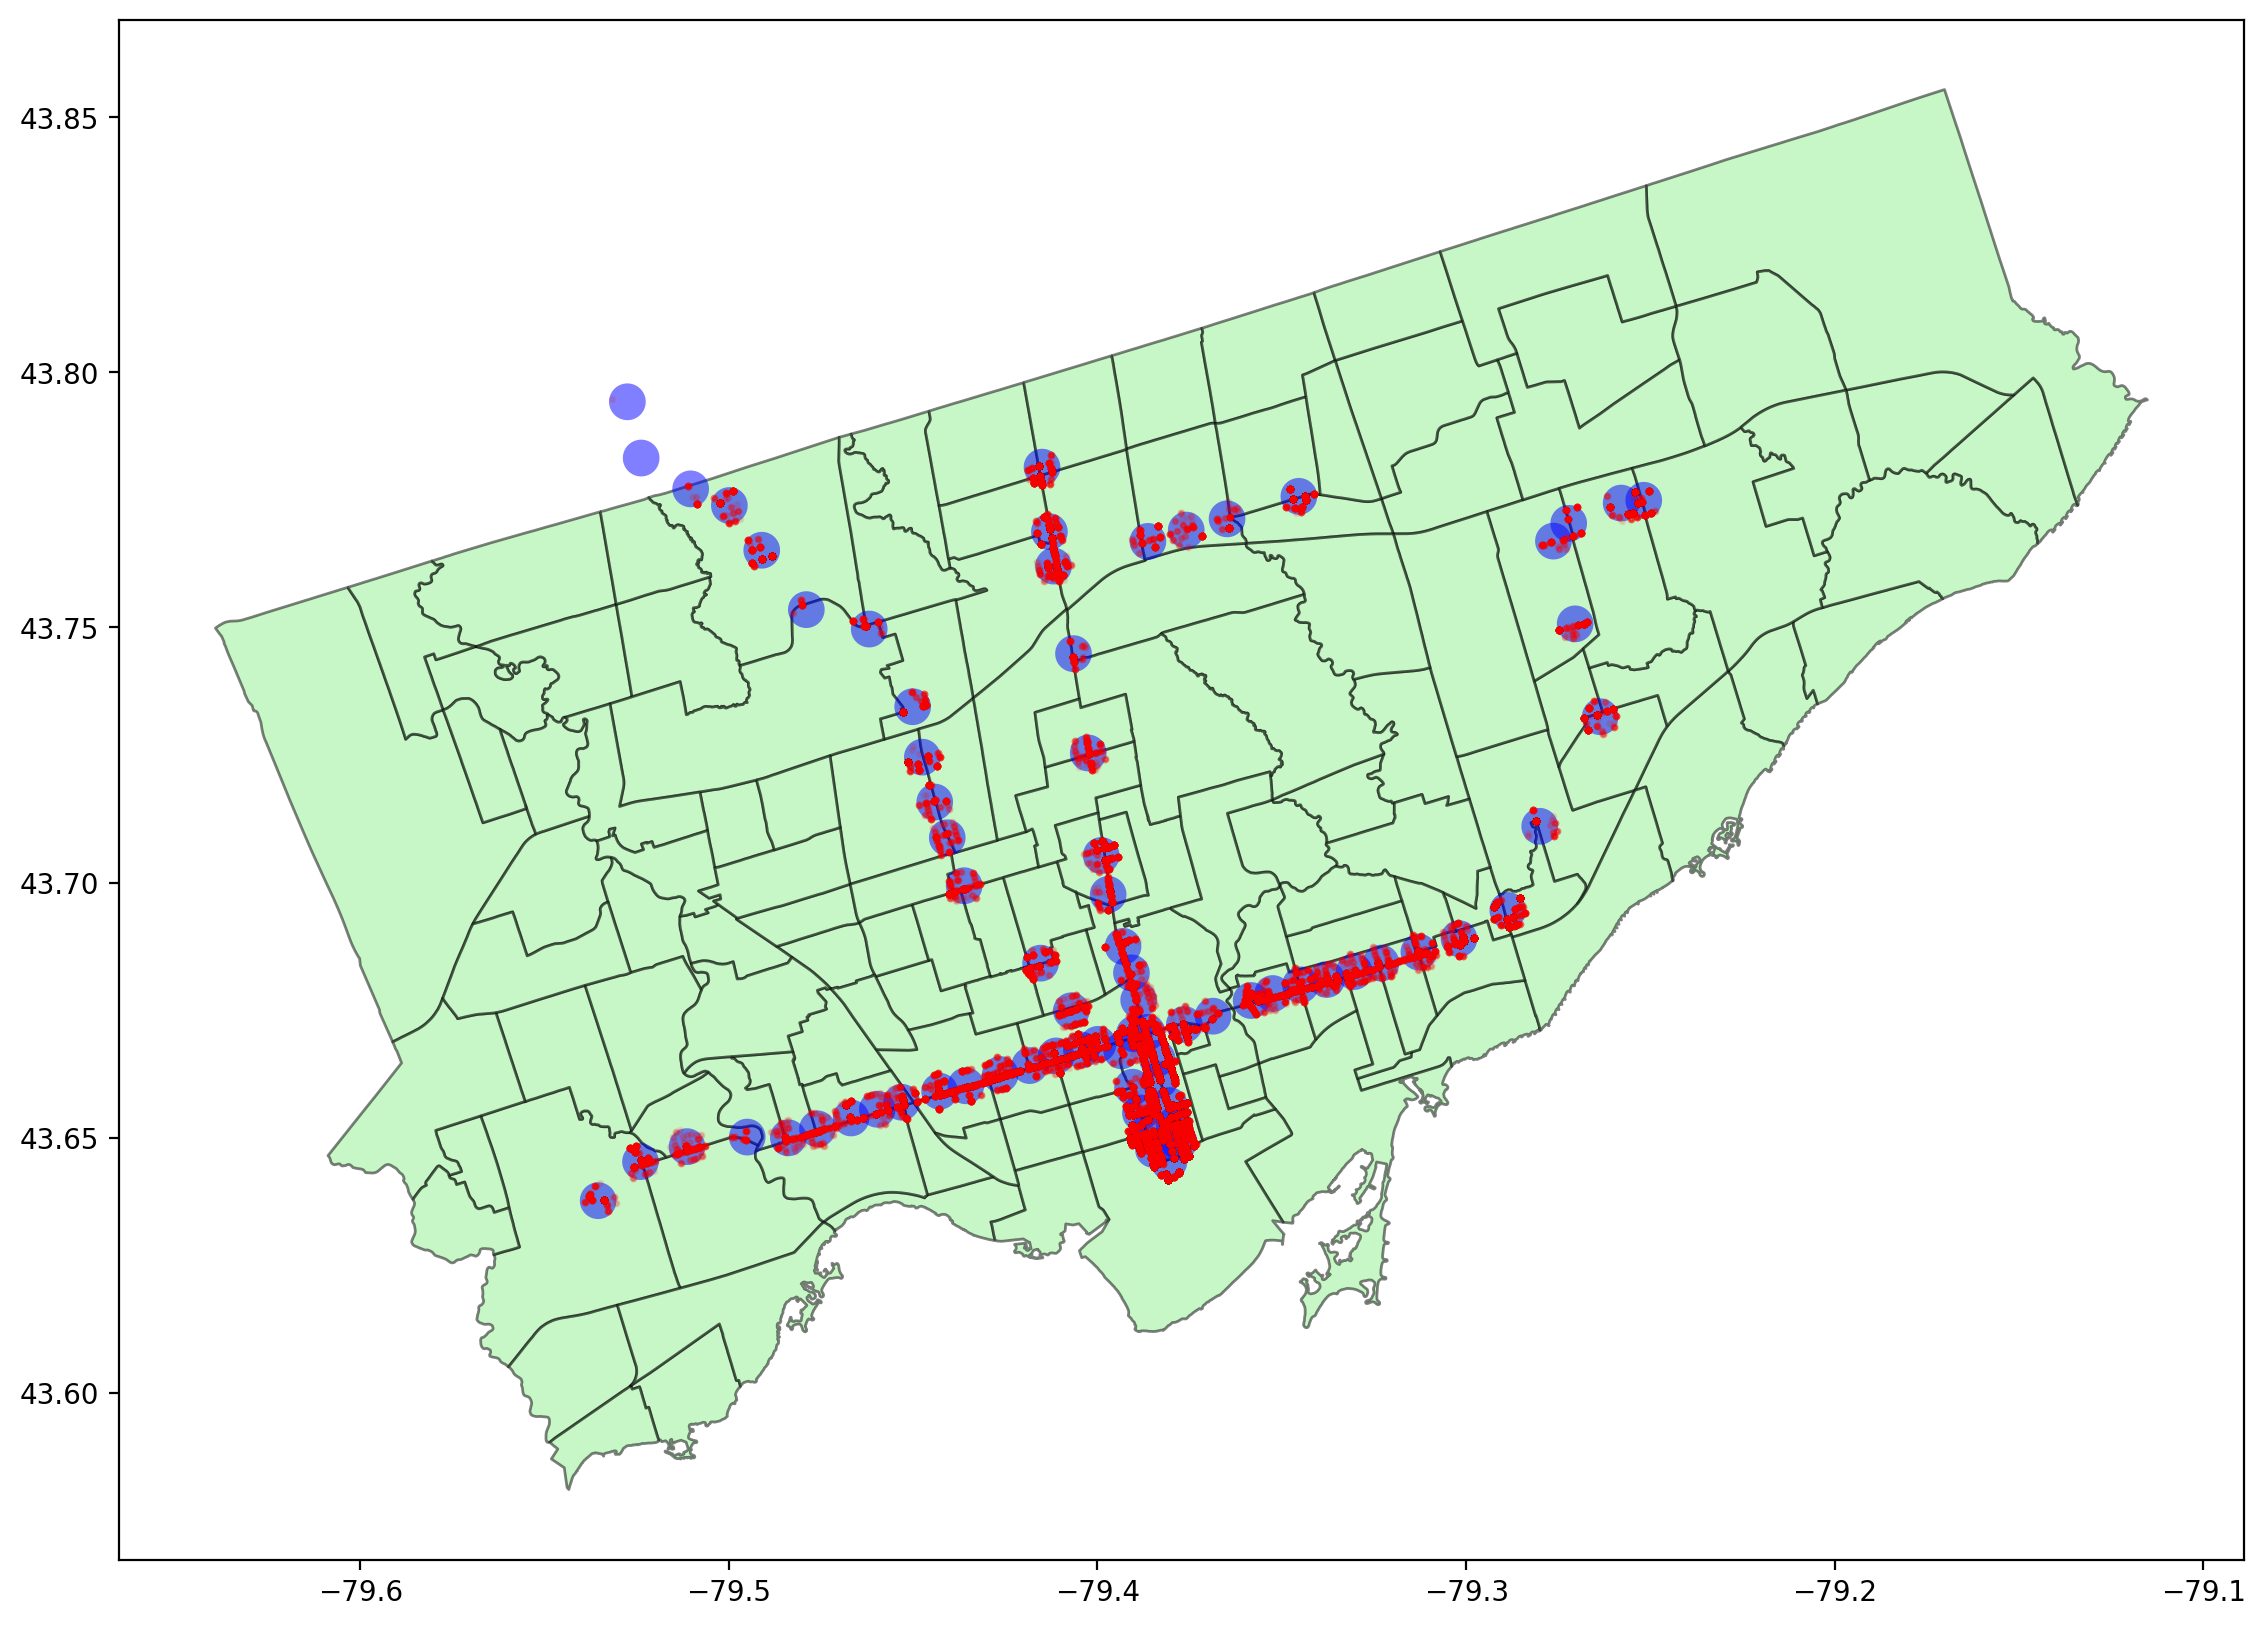

In [45]:
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
stations_area.plot(ax=ax, color = 'blue', markersize = 3, alpha = 0.5)
crime_around_stations.plot(ax=ax, color = 'red', markersize = 3, alpha = 0.1)

<AxesSubplot:>

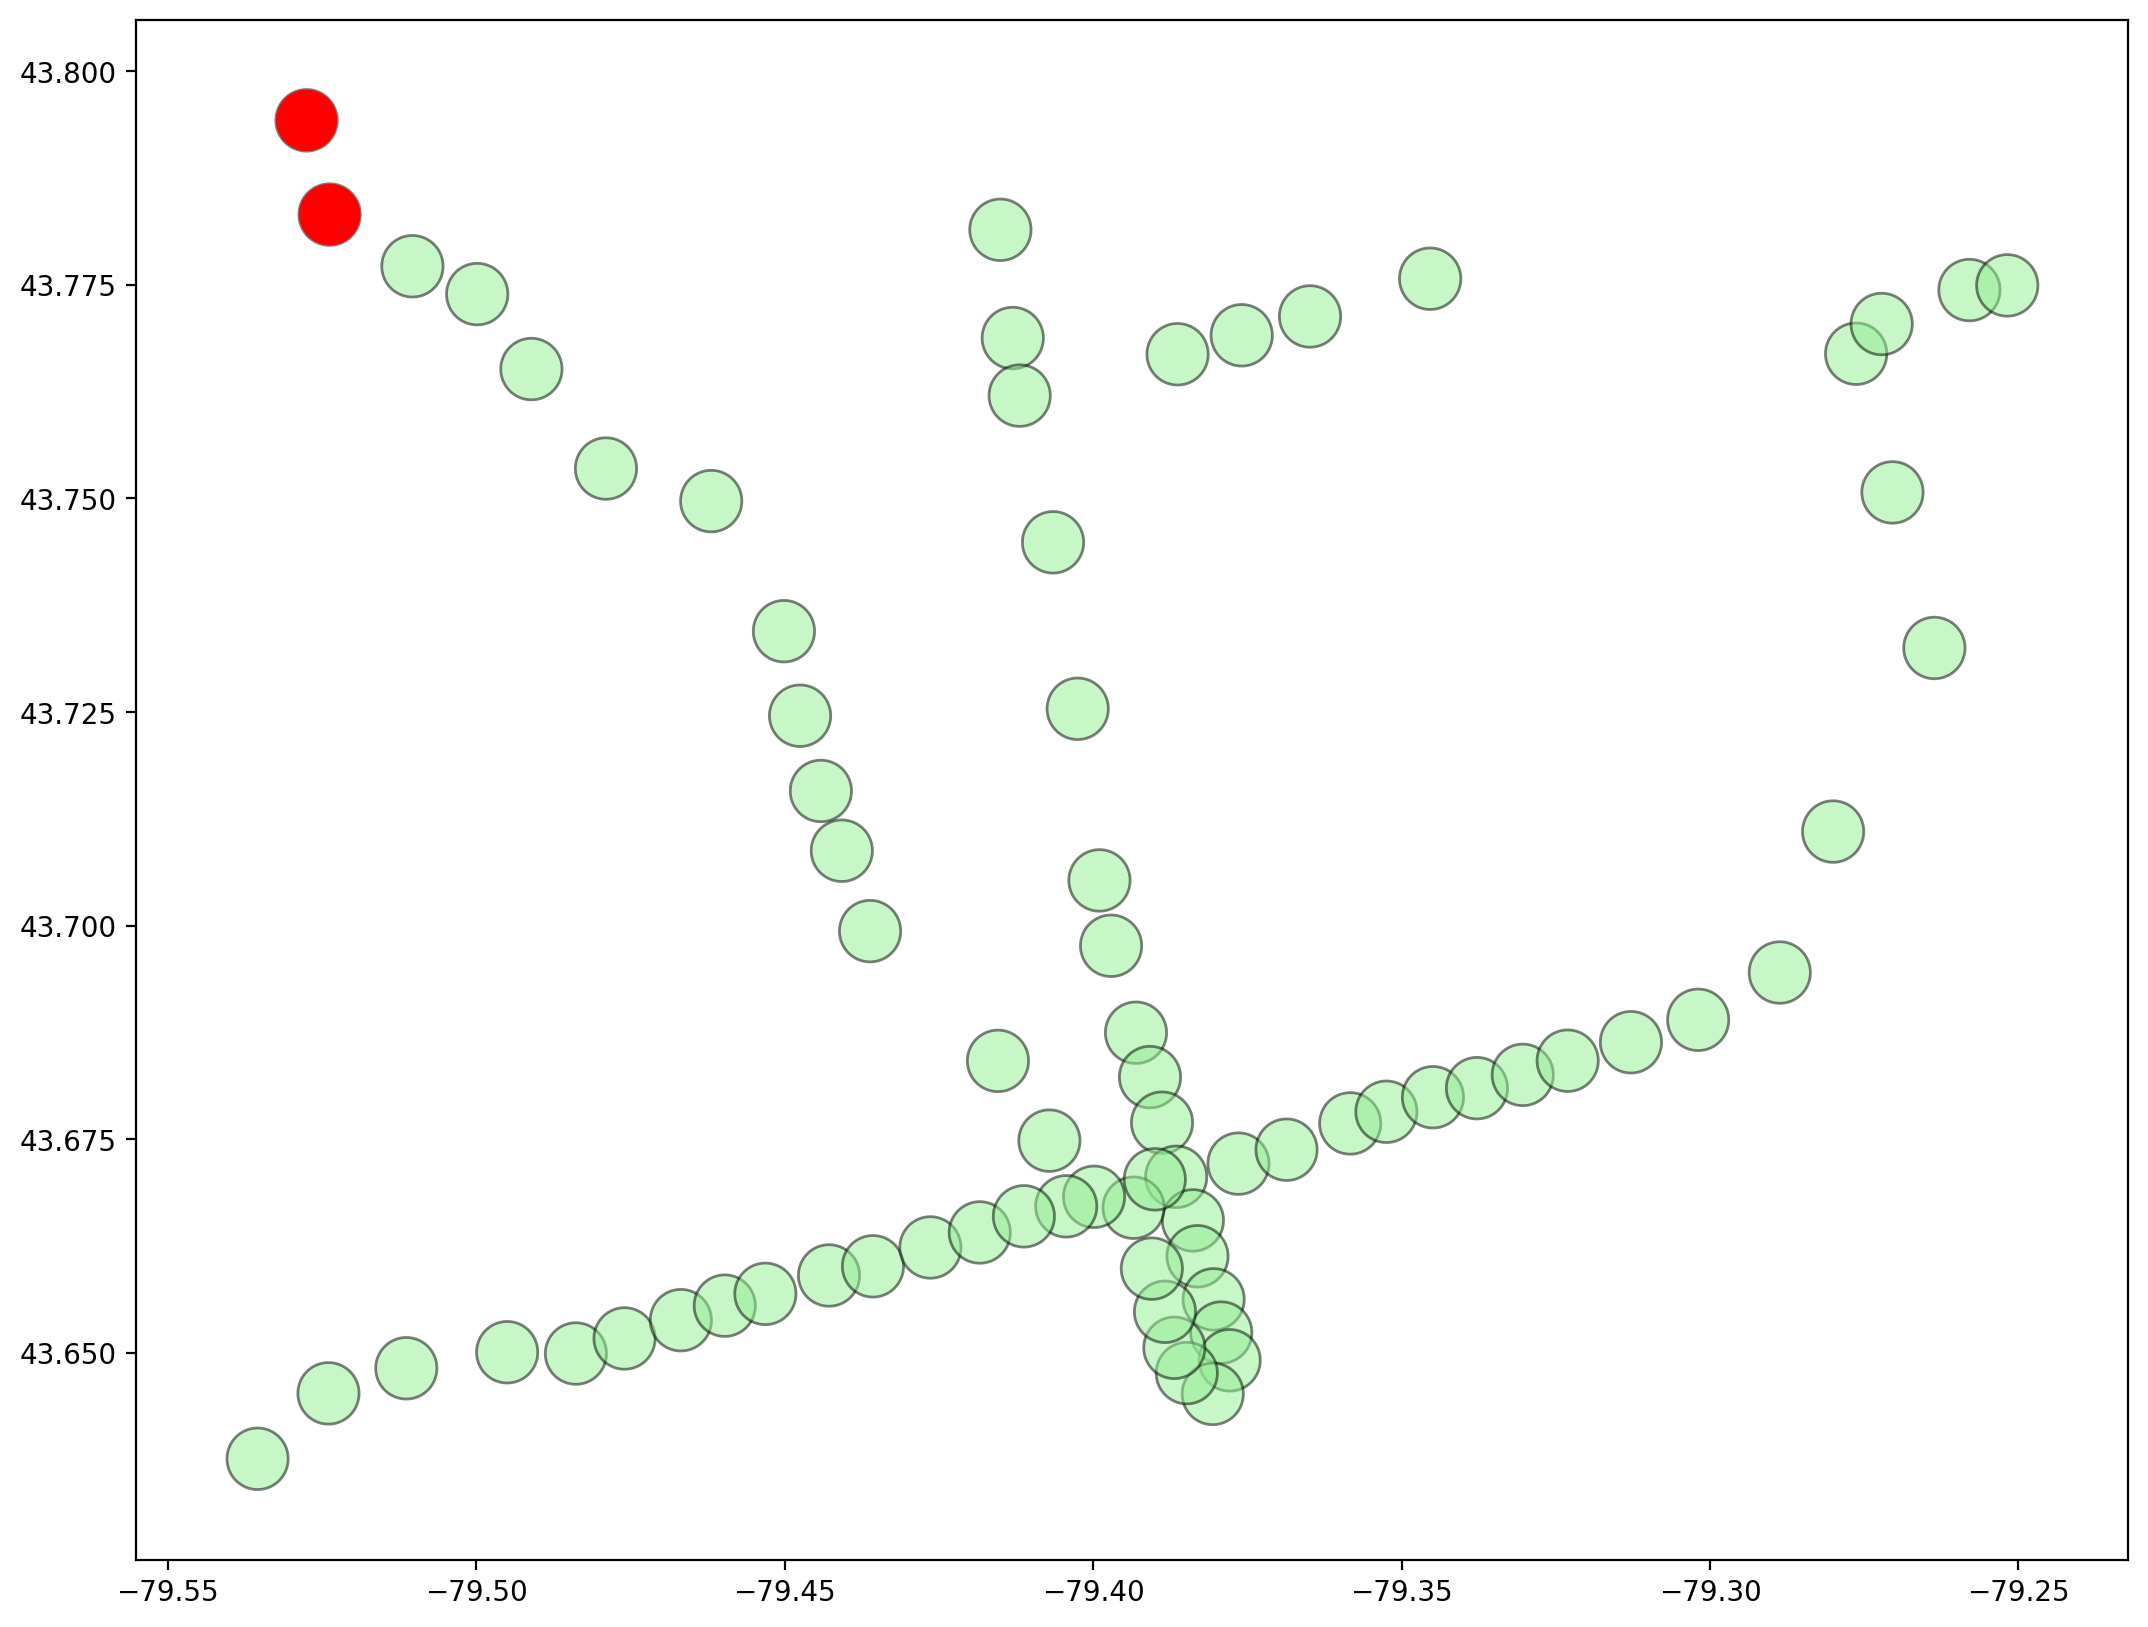

In [46]:
# checking there are actually crime around the 2 stations outside the neighbourhoods
ax = stations_area.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
stations_area[(stations_area['station'] == 'highway 407') | (stations_area['station'] == 'vaughan metropolitan centre')].plot(ax=ax, color = 'red', markersize = 3)

In [47]:
gpd.sjoin(mci_point, stations_area[(stations_area['station'] == 'highway 407') | (stations_area['station'] == 'vaughan metropolitan centre')],
          op='intersects')

C:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



X             Y  Index_ event_unique_id Division  \
230404 -8.853438e+06  5.433740e+06  233332  GO-20143349474      NSA   

                   occurrencedate            reporteddate premisetype  \
230404  2014-11-08 05:00:00+00:00  2014/11/22 05:00:00+00     Outside   

        ucr_code  ucr_ext  ... distance_km_order  commute_time_order  \
230404      2135      210  ...                74                  64   

                                                      url  \
230404  https://www.ttc.ca/subway-stations/vaughan-met...   

                            station                     line order  longitude  \
230404  vaughan metropolitan centre  Line 1 Yonge-University    37 -79.527487   

         latitude commute_time  distance_km  
230404  43.794244           44    18.050992  

[1 rows x 42 columns]

In [48]:
crime_around_stations.groupby('station')['event_unique_id'].count().sort_values(ascending=False)

station
dundas                         4856
college                        3633
queen                          3583
wellesley                      2983
bloor yonge                    2461
                               ... 
ellesmere                        83
old mill                         56
pioneer village                  53
downsview park                   42
vaughan metropolitan centre       1
Name: event_unique_id, Length: 74, dtype: int64

# Neighborhood crime rate

In [49]:
neighbourhood_count = pd.DataFrame(mci_point["Hood_ID"].value_counts())
neighbourhood_count = neighbourhood_count.reset_index().rename(columns = {'index': 'Hood_ID', 'Hood_ID': 'count'})
neighbourhood_count

Hood_ID  count
0        77   9645
1        75   8563
2        76   7619
3         1   6939
4        73   6382
..      ...    ...
136     140    496
137      97    486
138      60    473
139      29    472
140     114    405

[141 rows x 2 columns]